In [1]:
import os

import numpy as np
import pickle
import scipy.stats
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline  

from analysis import session
reload(session)

<module 'analysis.session' from 'analysis/session.pyc'>

In [2]:
# set the main data directory (this needs to be changed by each user)
maindir = '/media/colleen/LaCie/CredAssign/pilot_data'

omit_sess = [721038464] # alignment didn't work

n_mice = 4

# directory to save figures
figdir_run = 'figures/prelim_run'
figdir_roi = 'figures/prelim_roi'

In [3]:
mouse_df = pd.read_pickle('mouse_df.pkl')
allsessions = mouse_df.loc[(mouse_df['all_files'] == 1) & 
                           (mouse_df['sessionid'].isin(omit_sess) == False)]['sessionid'].tolist()

In [4]:
# create a dictionary with Session objects prepared for analysis
sdict = {}
for sess in allsessions:
    print("\nCreating session {}...".format(sess))
    sdict[sess] = session.Session(maindir,sess)    # creates a session object to work with
    sdict[sess].extract_info()                     # extracts necessary info for analysis
    print("finished session {}.".format(sess))


Creating session 712483302...
Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/ophys_session_712483302
Loading running data...
Loading ROI trace info...


finished session 712483302.

Creating session 712942208...
Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/ophys_session_712942208
Loading running data...
Loading ROI trace info...


finished session 712942208.

Creating session 715244457...
Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/ophys_session_715244457
Loading running data...
Loading ROI trace info...


finished session 715244457.

Creating session 716425232...
Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle alrea

Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/ophys_session_723323411
Loading running data...
Loading ROI trace info...



finished session 723323411.

Creating session 724421207...
Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/ophys_session_724421207
Loading running data...
Loading ROI trace info...



finished session 724421207.

Creating session 724422062...
Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/ophys_session_724422062
Loading running data...
Loading ROI trace info...



finished session 724422062.

Creating session 725009252...
Loading stimulus dictionary...
Loading alignment dataframe...
NOTE: Stimulus alignment pickle already exists in /media/colleen/LaCie/CredAssign/pilot_data/oph

In [5]:
# include criterion of passing QC?
include_qc = True
if include_qc:
    allsessions = mouse_df.loc[(mouse_df['all_files'] == 1) & 
                               (mouse_df['sessionid'].isin(omit_sess) == False) &
                               (mouse_df['pass_fail'] == 'P')]['sessionid'].tolist()
else:
    allsessions = mouse_df.loc[(mouse_df['all_files'] == 1) & 
                               (mouse_df['sessionid'].isin(omit_sess) == False)]['sessionid'].tolist()

# get first session for each mouse
first_sess = []
first_sess_n = []
for i in range(4):
    j = 1
    cont = True
    while cont:
        session = mouse_df.loc[(mouse_df['mouseid'] == i+1) & 
                               (mouse_df['overall_sess_n'] == j)]['sessionid'].tolist()[0]
        if session in allsessions:
            cont = False
        else:
            j += 1
    first_sess.append(sdict[session])
    first_sess_n.extend([session])
    
# get all sessions for each mouse, in order
all_sess = []
all_sess_n = []
for i in range(4):
    sessions = mouse_df.loc[(mouse_df['mouseid'] == i+1) & 
                           (mouse_df['sessionid'].isin(allsessions))]['sessionid'].tolist()
    order = mouse_df.loc[(mouse_df['sessionid'].isin(sessions))]['overall_sess_n'].tolist()
    sessions = [sess for _, sess in sorted(zip(order,sessions))]
    all_sess.append([sdict[s] for s in sessions])
    all_sess_n.append(sessions)

In [6]:
# get first sessions at specific depths
first_sess_hi = []
first_sess_hi_n = []
for i in range(4):
    sess_n = mouse_df.loc[(mouse_df['mouseid'] == i+1) & 
                          (mouse_df['depth'].isin([20, 75])) &
                          (mouse_df['sessionid'].isin(allsessions))]['overall_sess_n'].tolist()
    if len(sess_n) == 0:
        first_sess_hi.append(None)
        first_sess_hi_n.append(None)
    else:
        session = mouse_df.loc[(mouse_df['mouseid'] == i+1) & 
                           (mouse_df['overall_sess_n'] == sess_n[0]) &
                           (mouse_df['depth'].isin([20, 75]))]['sessionid'].tolist()[0]
        first_sess_hi.append(sdict[session])
        first_sess_hi_n.extend([session])
    
first_sess_lo = []
first_sess_lo_n = []
for i in range(4):
    sess_n = mouse_df.loc[(mouse_df['mouseid'] == i+1) & 
                          (mouse_df['depth'].isin([175, 375])) &
                          (mouse_df['sessionid'].isin(allsessions))]['overall_sess_n'].tolist()
    if len(sess_n) == 0:
        first_sess_lo.append(None)
        first_sess_lo_n.append(None)
    else:
        session = mouse_df.loc[(mouse_df['mouseid'] == i+1) & 
                           (mouse_df['overall_sess_n'] == sess_n[0]) &
                           (mouse_df['depth'].isin([175, 375]))]['sessionid'].tolist()[0]
        first_sess_lo.append(sdict[session])
        first_sess_lo_n.extend([session])

In [7]:
# plot medians as running data is not normally distributed
plot_stat = 'median'

In [8]:
# analyses start

In [9]:
# plot running across sessions
def plot_run(sess_list, fig_run, ax_run, title, stat=None):
    if stat == 'median':
        datasets = [np.median(x, axis=0) for x in [[sess.run for sess in sesses] for sesses in sess_list]]
    elif stat == 'mode':
        datasets = [np.mean(x, axis=0) for x in [[sess.run for sess in sesses] for sesses in sess_list]]
    elif stat is None:
        datasets = [sess.run for sess in sess_list]
    for i, data in enumerate(datasets):
        ax_run[i].plot(data, lw=0.1)
        if stat is None:
            ax_run[i].set_title('Mouse {} - Running across {}'.format(i+1, title), fontsize=22)
        else:
            ax_run[i].set_title('Mouse {} - M{} running across {}'.format(i+1, stat[1:], title), fontsize=22)
        if i == 1: # dropped running value for mouse 2
            ax_run[i].set_ylim(bottom=-15)    
        for item in (ax_run[i].get_xticklabels() + ax_run[i].get_yticklabels()):
            item.set_fontsize(18)
        ax_run[i].set_ylabel('Running speed (cm/s)', fontsize=18)
        
        # get the block boundaries, midpoints and params
        if stat is not None:
            sess = sess_list[i][0]
        else:
            sess = sess_list[i]
        bl_fr = [x for bl in sess.gabors.block_ran_fr for x in bl] + [x for bl in sess.bricks.block_ran_fr for x in bl]
        bl_par = [['gabors\n'] + [x] for bl in sess.gabors.block_params for x in bl] + \
                 [['bricks\n'] + x for bl in sess.bricks.block_params for x in bl]

        all_labels = []
        all_lines = []
        all_mids = []
        for frames, params in zip(bl_fr, bl_par):
            if isinstance(params, list):
                labels =  " ".join(str(item) for item in params)
            else:
                labels = str(params)
            all_labels.extend([labels])
            all_lines.extend(frames)
            all_mids.extend([np.mean(frames)])
        ymin, ymax = ax_run[i].get_ylim()
        ypos = (ymax-ymin)*0.85+ymin

        for line in all_lines:
            ax_run[i].axvline(x=line, ls='dashed', c='k', lw='1', alpha=0.5)
        for j, label in enumerate(all_labels):
            ax_run[i].text(all_mids[j], ypos, label, horizontalalignment='center', fontsize=20)
    fig_run.savefig('{}/run_{}.png'.format(figdir_run, title.replace(' ','_')), bbox_inches='tight')

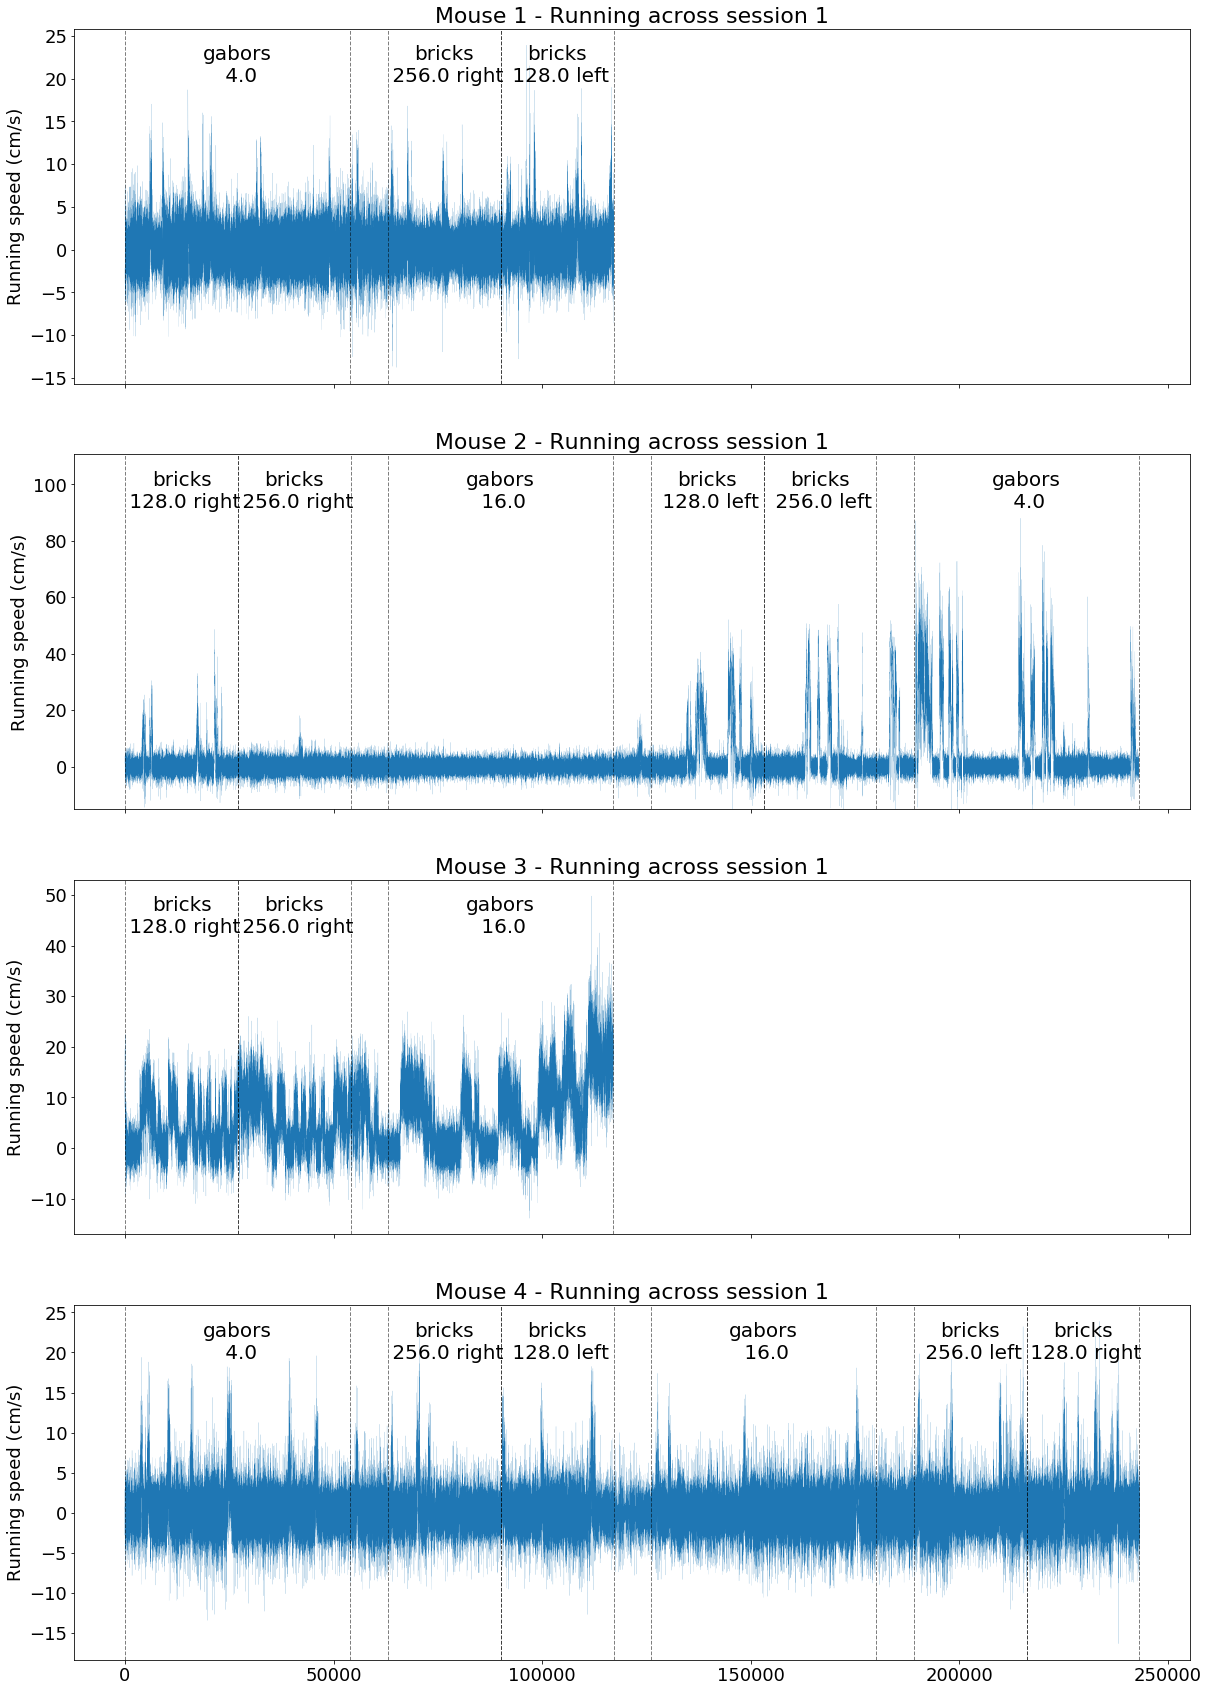

In [8]:
# plot all running
fig_run_first, ax_run_first = plt.subplots(nrows=n_mice, sharex=True, figsize=(20, 30))
plot_run(first_sess, fig_run_first, ax_run_first, 'session 1')


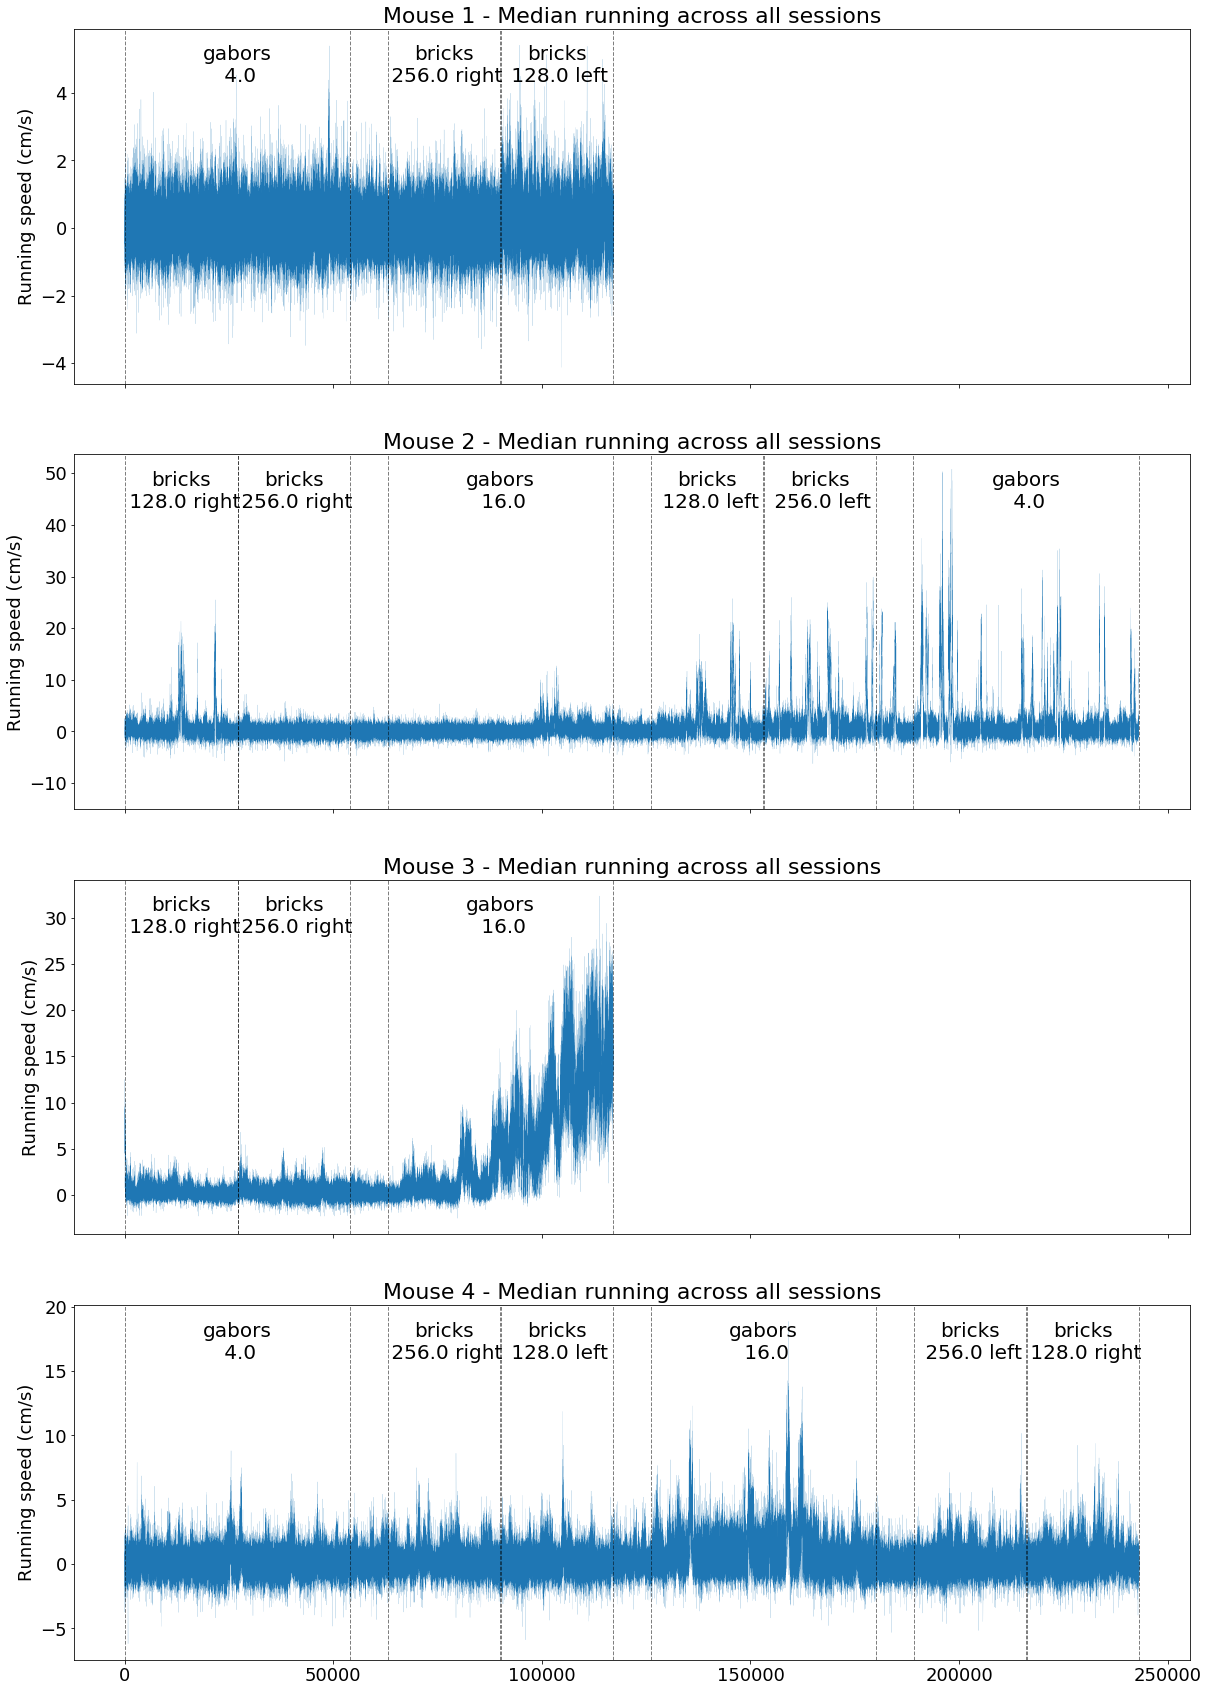

In [9]:
# plot all running, medians across sessions
fig_run_all, ax_run_all = plt.subplots(nrows=n_mice, sharex=True, figsize=(20, 30))
plot_run(all_sess, fig_run_all, ax_run_all, 'all sessions', 'median')

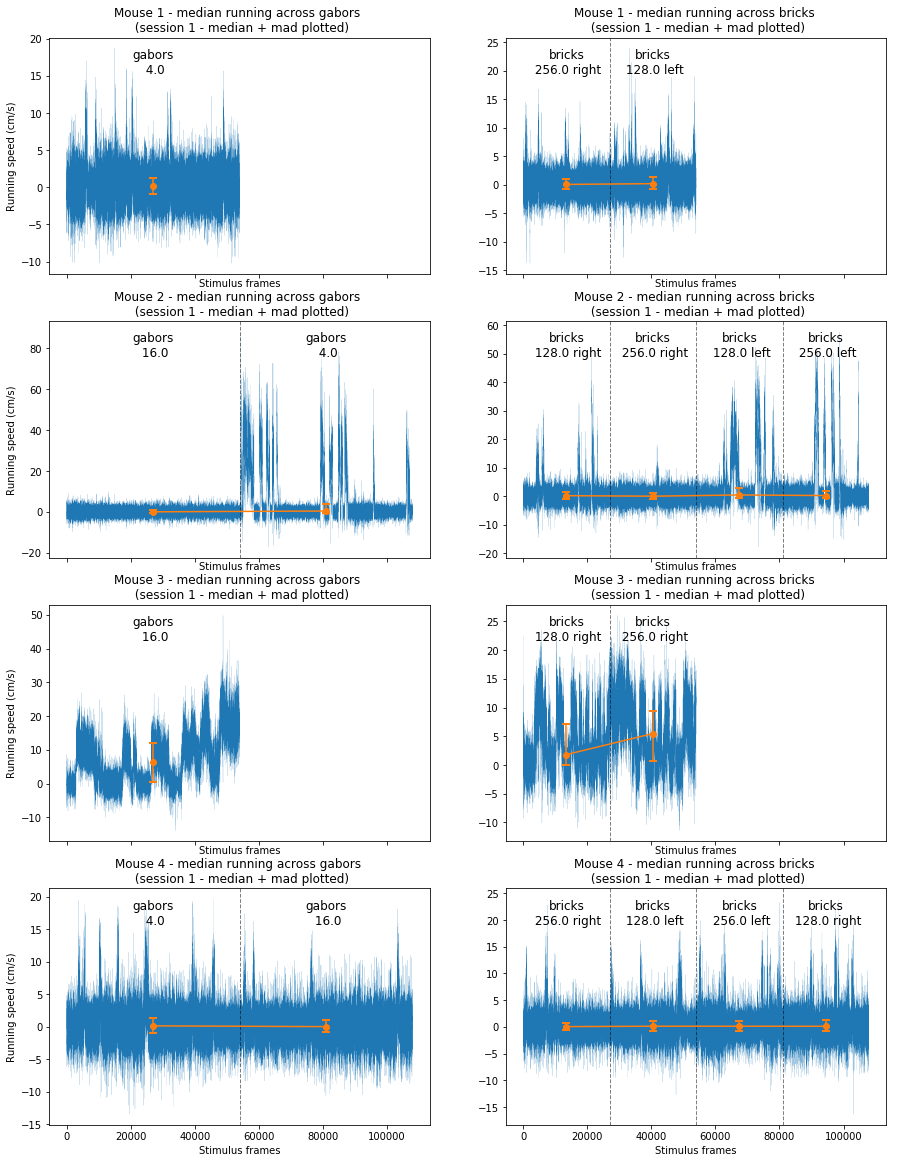

In [10]:
# running during bricks versus gabors

# plot running across all blocks
fig_bl_run, ax_bl_run = plt.subplots(ncols=2, nrows=n_mice, 
                                     sharex=True, figsize=(15, 20))

for i, sess in enumerate(first_sess):
    gab_run_all = sess.gabors.get_run(by='frame')
    gab_run_bybl = sess.gabors.get_run(by='block')
    gab_bl_mks = np.cumsum([x for sub in sess.gabors.block_len_fr 
                            for x in sub])[:-1].tolist()

    if plot_stat == 'mean':
        gab_run_me_bybl  = [np.mean(x) for x 
                            in gab_run_bybl]
        gab_run_err_bybl = [np.std(x) for x 
                            in gab_run_bybl]
    elif plot_stat == 'median':
        gab_run_me_bybl = [np.median(x) for x 
                               in gab_run_bybl]

        gab_run_qu_bybl = [[np.percentile(x, 25) for x 
                            in gab_run_bybl], 
                           [np.percentile(x, 75) for x 
                            in gab_run_bybl]]
        gab_run_err_bybl = [[median - qu25 for median, qu25 in zip(gab_run_me_bybl, gab_run_qu_bybl[0])],
                            [qu75 - median for median, qu75 in zip(gab_run_me_bybl, gab_run_qu_bybl[1])]]
    temp = np.asarray([0] + [x for sub in sess.gabors.block_len_fr 
                             for x in sub])
    gab_run_me_mks = (np.cumsum(temp)[0:-1] + np.cumsum(temp)[1:])/2
    gab_run_me_lbs = []
    for label in [['gabors\n'] + [x] for bl in sess.gabors.block_params for x in bl]:
        if isinstance(label, list):
            label =  " ".join(str(item) for item in label)
        else:
            label = str(label)
        gab_run_me_lbs.extend([label])

    bri_run_all = sess.bricks.get_run(by='frame')
    bri_run_bybl = sess.bricks.get_run(by='block')
    bri_bl_mks = np.cumsum([x for sub in sess.bricks.block_len_fr 
                            for x in sub])[:-1].tolist()

    if plot_stat == 'mean':
        bri_run_me_bybl = [np.mean(x) for x 
                           in bri_run_bybl]
        bri_run_err_bybl = [np.std(x) for x 
                            in bri_run_bybl]
    elif plot_stat == 'median':
        bri_run_me_bybl = [np.median(x) for x 
                           in bri_run_bybl]
        bri_run_qu_bybl = [[np.percentile(x, 25) for x 
                            in bri_run_bybl], 
                           [np.percentile(x, 75) for x 
                            in bri_run_bybl]]
        bri_run_err_bybl = [[median - qu25 for median, qu25 in zip(bri_run_me_bybl, bri_run_qu_bybl[0])],
                            [qu75 - median for median, qu75 in zip(bri_run_me_bybl, bri_run_qu_bybl[1])]]
    temp = np.asarray([0] + [x for sub 
                             in sess.bricks.block_len_fr for x in sub])
    bri_run_me_mks = (np.cumsum(temp)[0:-1] + np.cumsum(temp)[1:])/2
    bri_run_me_lbs = []
    for label in [['bricks\n'] + x for bl in sess.bricks.block_params for x in bl]:
        if isinstance(label, list):
            label =  " ".join(str(item) for item in label)
        else:
            label = str(label)
        bri_run_me_lbs.extend([label])

    # plot running across gabor blocks
    ax_bl_run[i][0].plot(gab_run_all, lw=0.1, zorder=-30)
    ax_bl_run[i][0].errorbar(gab_run_me_mks, gab_run_me_bybl, 
                          yerr=gab_run_err_bybl, fmt='-o', capsize=4, 
                          capthick=2)
    if plot_stat == 'mean':
        ax_bl_run[i][0].set_title('Mouse {} - mean running across gabors \n (session 1 - mean + sem plotted)'.format(i+1))
    elif plot_stat == 'median':
        ax_bl_run[i][0].set_title('Mouse {} - median running across gabors \n (session 1 - median + qu plotted)'.format(i+1))
    ax_bl_run[i][0].set_ylabel('Running speed (cm/s)')
    ax_bl_run[i][0].set_xlabel('Stimulus frames')
    ymin, ymax = ax_bl_run[i][0].get_ylim()
    ypos = (ymax-ymin)*0.85+ymin
    if len(gab_bl_mks) > 0:
        for line in gab_bl_mks:
            ax_bl_run[i][0].axvline(x=line, ls='dashed', c='k', lw='1', alpha=0.5)
    for j, label in enumerate(gab_run_me_lbs):
        ax_bl_run[i][0].text(gab_run_me_mks[j], ypos, label, horizontalalignment='center', fontsize=12)

    # plot running across brick blocks
    ax_bl_run[i][1].plot(bri_run_all, lw=0.1, zorder=-30)
    ax_bl_run[i][1].errorbar(bri_run_me_mks, bri_run_me_bybl, 
                          yerr=bri_run_err_bybl, fmt='-o', capsize=4, 
                          capthick=2)
    if plot_stat == 'mean':
        ax_bl_run[i][1].set_title('Mouse {} - mean running across bricks \n (session 1 - mean + sem plotted)'.format(i+1))
    elif plot_stat == 'median':
        ax_bl_run[i][1].set_title('Mouse {} - median running across bricks \n (session 1 - median + qu plotted)'.format(i+1))
    ax_bl_run[i][1].set_xlabel('Stimulus frames')
    ymin, ymax = ax_bl_run[i][1].get_ylim()
    ypos = (ymax-ymin)*0.85+ymin
    if len(bri_bl_mks) > 0:
        for line in bri_bl_mks:
            ax_bl_run[i][1].axvline(x=line, ls='dashed', c='k', lw='1', alpha=0.5)
    for j, label in enumerate(bri_run_me_lbs):
        ax_bl_run[i][1].text(bri_run_me_mks[j], ypos, label, horizontalalignment='center', fontsize=12)

fig_bl_run.savefig('{}/run_session_1_blocks.png'.format(figdir_run), bbox_inches='tight')

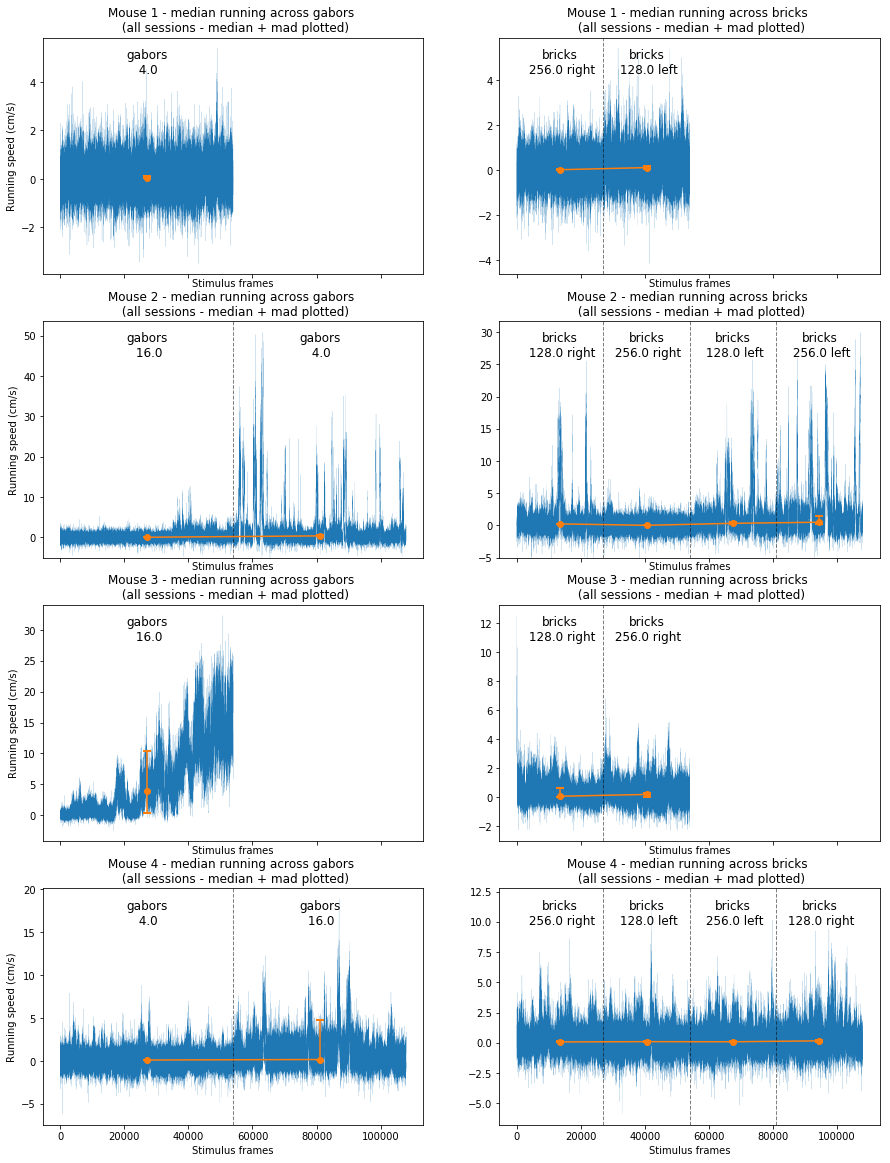

In [11]:
# running during bricks versus gabors (averaged over sessions)

# plot running across all blocks
fig_bl_run, ax_bl_run = plt.subplots(ncols=2, nrows=n_mice, 
                                     sharex=True, figsize=(15, 20))

for i, sesses in enumerate(all_sess):
    gab_run_alls = []
    gab_run_me_bybls = []
    bri_run_alls = []
    bri_run_me_bybls = []
    for sess in sesses: 
        gab_run_alls.append(np.asarray(sess.gabors.get_run(by='frame')))
        gab_run_bybl = sess.gabors.get_run(by='block')

        if plot_stat == 'mean':
            gab_run_me_bybls.append(np.asarray([np.mean(x) for x 
                                                in gab_run_bybl]))
        elif plot_stat == 'median':
            gab_run_me_bybls.append(np.asarray([np.median(x) for x 
                                                in gab_run_bybl]))

        bri_run_alls.append(sess.bricks.get_run(by='frame'))
        bri_run_bybl = sess.bricks.get_run(by='block')

        if plot_stat == 'mean':
            bri_run_me_bybls.append(np.asarray([np.mean(x) for x 
                                                in bri_run_bybl]))
        elif plot_stat == 'median':
            bri_run_me_bybls.append(np.asarray([np.median(x) for x 
                                                in bri_run_bybl]))        
    
    if plot_stat == 'mean':
        gab_run_all = np.mean(np.asarray(gab_run_alls), axis=0)
        bri_run_all = np.mean(np.asarray(bri_run_alls), axis=0)
    
        gab_run_me_bybl = np.mean(np.asarray(gab_run_me_bybls), axis=0)
        gab_run_err_bybl = scipy.stats.sem(np.asarray(gab_run_me_bybls), axis=0)

        bri_run_me_bybl = np.mean(np.asarray(bri_run_me_bybls), axis=0)
        bri_run_err_bybl = scipy.stats.sem(np.asarray(bri_run_me_bybls), axis=0)
    
    elif plot_stat == 'median':
        gab_run_all = np.median(np.asarray(gab_run_alls), axis=0)
        bri_run_all = np.median(np.asarray(bri_run_alls), axis=0)
    
        gab_run_me_bybl = np.median(np.asarray(gab_run_me_bybls), axis=0)
        gab_run_qu25_bybl = np.percentile(np.asarray(gab_run_me_bybls), 25, axis=0)
        gab_run_qu75_bybl = np.percentile(np.asarray(gab_run_me_bybls), 75, axis=0)
        gab_run_err_bybl = [gab_run_me_bybl - gab_run_qu25_bybl, 
                            gab_run_qu75_bybl - gab_run_me_bybl]

        bri_run_me_bybl = np.median(np.asarray(bri_run_me_bybls), axis=0)
        bri_run_qu25_bybl = np.percentile(np.asarray(bri_run_me_bybls), 25, axis=0)
        bri_run_qu75_bybl = np.percentile(np.asarray(bri_run_me_bybls), 75, axis=0)
        bri_run_err_bybl = [bri_run_me_bybl - bri_run_qu25_bybl, 
                            bri_run_qu75_bybl - bri_run_me_bybl]
        
    
    # median/mean marks
    gab_bl_mks = np.cumsum([x for sub in sess.gabors.block_len_fr 
                                for x in sub])[:-1].tolist()
    temp = np.asarray([0] + [x for sub in sess.gabors.block_len_fr 
                                 for x in sub])
    gab_run_me_mks = (np.cumsum(temp)[0:-1] + np.cumsum(temp)[1:])/2
    gab_run_me_lbs = []
    for label in [['gabors\n'] + [x] for bl in sess.gabors.block_params for x in bl]:
        if isinstance(label, list):
            label =  " ".join(str(item) for item in label)
        else:
            label = str(label)
        gab_run_me_lbs.extend([label])

    bri_bl_mks = np.cumsum([x for sub in sess.bricks.block_len_fr 
                            for x in sub])[:-1].tolist()

    temp = np.asarray([0] + [x for sub 
                             in sess.bricks.block_len_fr for x in sub])
    bri_run_me_mks = (np.cumsum(temp)[0:-1] + np.cumsum(temp)[1:])/2
    bri_run_me_lbs = []
    for label in [['bricks\n'] + x for bl in sess.bricks.block_params for x in bl]:
        if isinstance(label, list):
            label =  " ".join(str(item) for item in label)
        else:
            label = str(label)
        bri_run_me_lbs.extend([label])

    # plot running across gabor blocks
    ax_bl_run[i][0].plot(gab_run_all, lw=0.1, zorder=-30)
    ax_bl_run[i][0].errorbar(gab_run_me_mks, gab_run_me_bybl, 
                          yerr=gab_run_err_bybl, fmt='-o', capsize=4, 
                          capthick=2)
    if plot_stat == 'mean':
        ax_bl_run[i][0].set_title('Mouse {} - mean running across gabors \n (all sessions - mean + sem plotted)'.format(i+1))
    elif plot_stat == 'median':
        ax_bl_run[i][0].set_title('Mouse {} - median running across gabors \n (all sessions - median + qu plotted)'.format(i+1))
    ax_bl_run[i][0].set_ylabel('Running speed (cm/s)')
    ax_bl_run[i][0].set_xlabel('Stimulus frames')
    if i == 1:
        ax_bl_run[i][0].set_ylim(bottom=-5)
    ymin, ymax = ax_bl_run[i][0].get_ylim()
    ypos = (ymax-ymin)*0.85+ymin
    if len(gab_bl_mks) > 0:
        for line in gab_bl_mks:
            ax_bl_run[i][0].axvline(x=line, ls='dashed', c='k', lw='1', alpha=0.5)
    for j, label in enumerate(gab_run_me_lbs):
        ax_bl_run[i][0].text(gab_run_me_mks[j], ypos, label, 
                             horizontalalignment='center', fontsize=12)
        
    # plot running across brick blocks
    ax_bl_run[i][1].plot(bri_run_all, lw=0.1, zorder=-30)
    ax_bl_run[i][1].errorbar(bri_run_me_mks, bri_run_me_bybl, 
                          yerr=bri_run_err_bybl, fmt='-o', capsize=4, 
                          capthick=2)
    if plot_stat == 'mean':
        ax_bl_run[i][1].set_title('Mouse {} - mean running across bricks \n (all sessions - mean + sem plotted)'.format(i+1))
    elif plot_stat == 'median':
        ax_bl_run[i][1].set_title('Mouse {} - median running across bricks \n (all sessions - median + qu plotted)'.format(i+1))
    ax_bl_run[i][1].set_xlabel('Stimulus frames')
    if i == 1:
        ax_bl_run[i][1].set_ylim(bottom=-5)
    ymin, ymax = ax_bl_run[i][1].get_ylim()
    ypos = (ymax-ymin)*0.85+ymin
    if len(bri_bl_mks) > 0:
        for line in bri_bl_mks:
            ax_bl_run[i][1].axvline(x=line, ls='dashed', c='k', lw='1', alpha=0.5)
    for j, label in enumerate(bri_run_me_lbs):
        ax_bl_run[i][1].text(bri_run_me_mks[j], ypos, label, 
                             horizontalalignment='center', fontsize=12)

fig_bl_run.savefig('{}/run_all_sessions_blocks.png'.format(figdir_run), bbox_inches='tight')

In [9]:
# function to plot chunks of frames
def plot_chunks(ax, chunk_val, stats, title='', lw=1.5, btwc='lightblue', hbars=None, bars=None, labels=None, xpos=None, t_hei=0.65, col='k'):
    ax.plot(chunk_val[0], chunk_val[1], lw=lw)
    if stats == 'mean':
        ax.fill_between(chunk_val[0], chunk_val[1] - chunk_val[2], 
                        chunk_val[1] + chunk_val[2], 
                        facecolor=btwc, alpha=0.5)
    elif stats == 'median':
        ax.fill_between(chunk_val[0], chunk_val[2][0], chunk_val[2][1], 
                        facecolor=btwc, alpha=0.5)
    thickness = [2, 1]
    torem = []
    for i, j in enumerate([hbars, bars]):
        if j is not None:
            if not isinstance(j, list):
                j = [j]
            if i == 0:
                torem = j
            if i == 1:
                for r in torem:
                    if r in j:
                        j.remove(r)
            for k in j:
                ax.axvline(x=k, ls='dashed', c='k', lw='{}'
                           .format(thickness[i]), alpha=0.5)  
    if labels is not None and xpos is not None:
        if len(labels) != len(xpos):
            raise IOError('Arguments \'labels\' and \'xpos\' must be of the same length.')
        ymin, ymax = ax.get_ylim()
        ypos = (ymax-ymin)*t_hei+ymin
        for l, x in zip(labels, xpos):
            ax.text(x, ypos, l, horizontalalignment='center', fontsize=15, color=col)
    ax.set_title(title)
    ax.set_ylabel('Running speed (cm/s)')
    ax.set_xlabel('Time (s)')

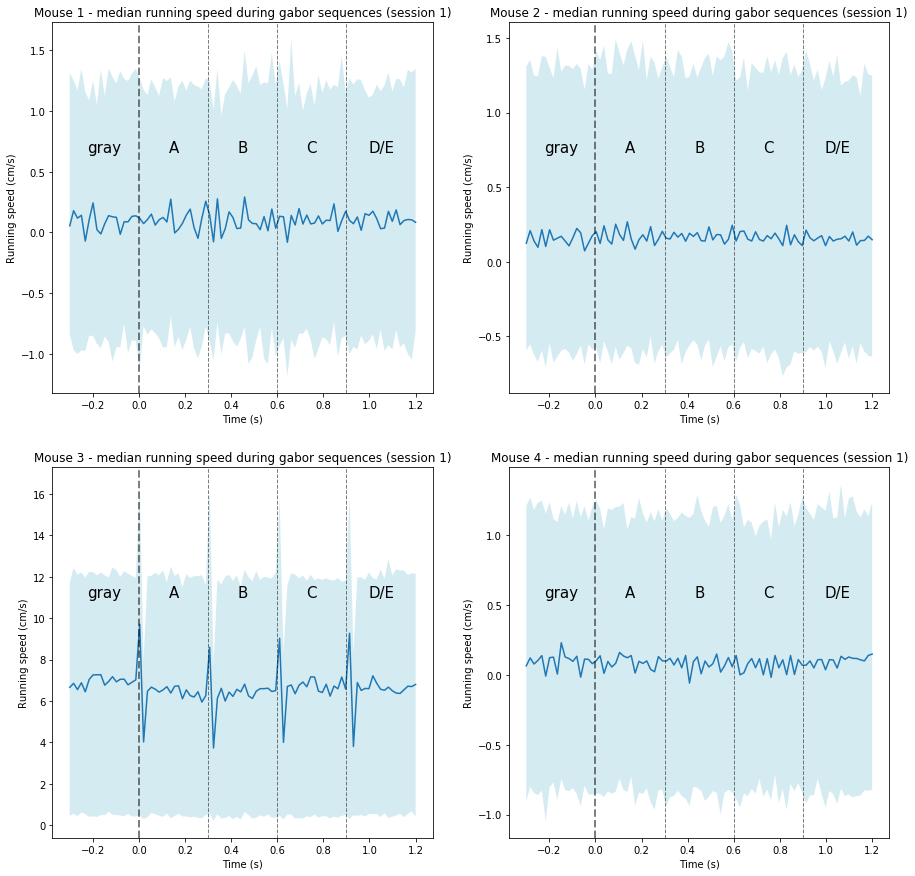

In [13]:
# plot average running through gabor sequences for session 1
# returns x_ran, run_chunks_me, run_chunks_de
rand=False
gab_chunk = []
for sess in first_sess:
    gab_chunk.append(sess.gabors.get_run_chunk_stats(sess.gabors.get_A_frame_1s(by='frame'), 
                                                     sess.gabors.pre, sess.gabors.post, rand=rand,
                                                     stats=plot_stat))

# draw lines
h_bars = [0] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = np.linspace(-sess.gabors.pre,sess.gabors.post, 
                       num=sess.gabors.n_seg_per_set+2)[1:-1].tolist()
labels = ['gray', 'A', 'B', 'C', 'D/E']
xpos = [-0.15, 0.15, 0.45, 0.75, 1.05]
    
# plot
fig_gabA, ax_gabA = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gabA[i/2][i%2], gab_chunk[i], plot_stat,
                title='Mouse {} - m{} running speed during gabor sequences (session 1)'
                .format(i+1, plot_stat[1:]), 
                hbars=h_bars, bars=seg_bars, labels=labels, xpos=xpos)
fig_gabA.savefig('{}/run_session_1_gabors.png'.format(figdir_run), bbox_inches='tight')

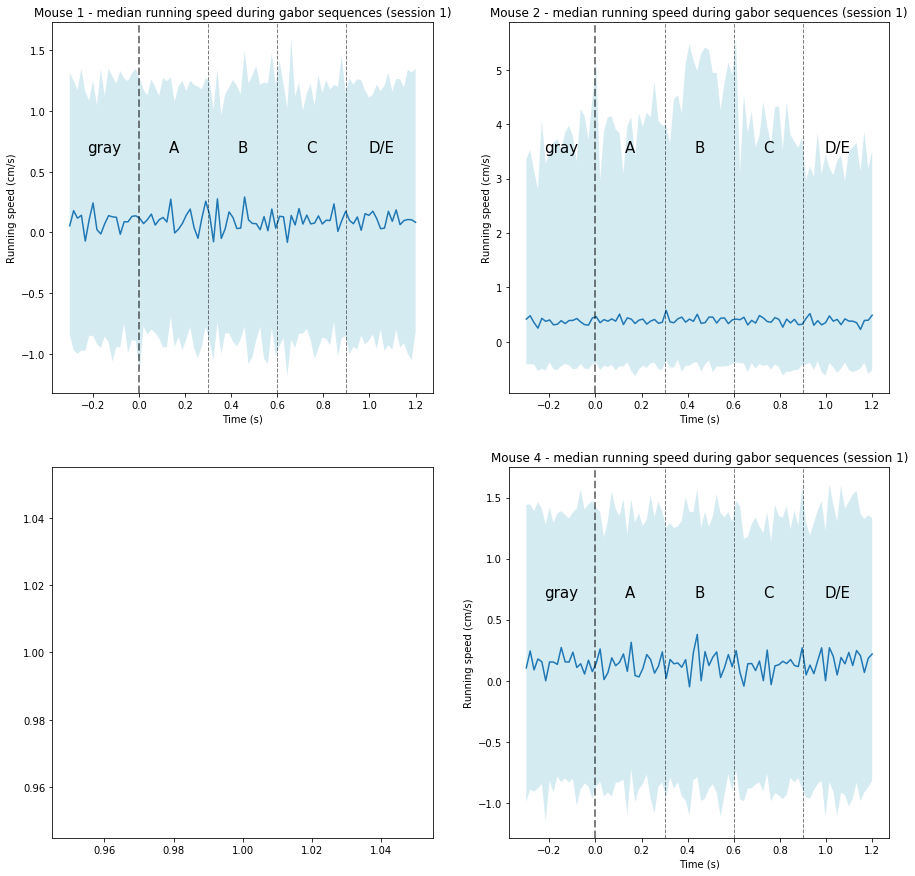

In [14]:
# plot average running through gabor sequences for session 1 for stimPar2
# returns x_ran, run_chunks_me, run_chunks_de
rand=False
stimPar2 = 4 # 16
gab_chunk = []
for sess in first_sess:
    try:
        gab_chunk.append(sess.gabors.get_run_chunk_stats(sess.gabors.get_frames_by_criteria(gaborframe=0, stimPar2=stimPar2, by='frame'), 
                                                         sess.gabors.pre, sess.gabors.post, rand=rand,
                                                         stats=plot_stat))
    except:
        gab_chunk.append([1, 1, 1])

# draw lines
h_bars = [0] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = np.linspace(-sess.gabors.pre,sess.gabors.post, 
                       num=sess.gabors.n_seg_per_set+2)[1:-1].tolist()
labels = ['gray', 'A', 'B', 'C', 'D/E']
xpos = [-0.15, 0.15, 0.45, 0.75, 1.05]
    
# plot
fig_gabA, ax_gabA = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    try:
        plot_chunks(ax_gabA[i/2][i%2], gab_chunk[i], plot_stat,
                    title='Mouse {} - m{} running speed during gabor sequences (session 1)'
                    .format(i+1, plot_stat[1:]), 
                    hbars=h_bars, bars=seg_bars, labels=labels, xpos=xpos)
    except:
        pass
fig_gabA.savefig('{}/run_session_1_gabors_{}.png'.format(figdir_run, stimPar2), bbox_inches='tight')

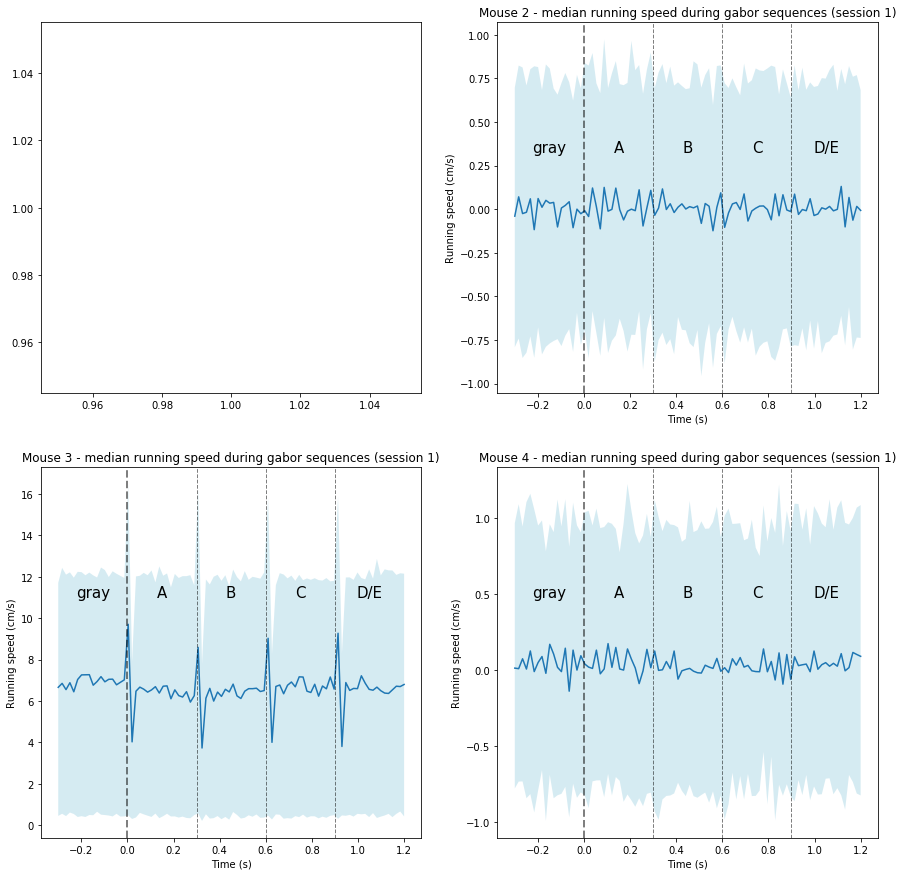

In [15]:
# plot average running through gabor sequences for session 1 for stimPar2
# returns x_ran, run_chunks_me, run_chunks_de
rand=False
stimPar2 = 16 # or 16
gab_chunk = []
for sess in first_sess:
    try:
        gab_chunk.append(sess.gabors.get_run_chunk_stats(sess.gabors.get_frames_by_criteria(gaborframe=0, stimPar2=stimPar2, by='frame'), 
                                                         sess.gabors.pre, sess.gabors.post, rand=rand,
                                                         stats=plot_stat))
    except:
        gab_chunk.append([1, 1, 1])

# draw lines
h_bars = [0] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = np.linspace(-sess.gabors.pre,sess.gabors.post, 
                       num=sess.gabors.n_seg_per_set+2)[1:-1].tolist()
labels = ['gray', 'A', 'B', 'C', 'D/E']
xpos = [-0.15, 0.15, 0.45, 0.75, 1.05]
    
# plot
fig_gabA, ax_gabA = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    try:
        plot_chunks(ax_gabA[i/2][i%2], gab_chunk[i], plot_stat,
                    title='Mouse {} - m{} running speed during gabor sequences (session 1)'
                    .format(i+1, plot_stat[1:]), 
                    hbars=h_bars, bars=seg_bars, labels=labels, xpos=xpos)
    except:
        pass
fig_gabA.savefig('{}/run_session_1_gabors_{}.png'.format(figdir_run, stimPar2), bbox_inches='tight')

In [16]:
# get mean/median and sem/qu for chunks
def get_chunk_me_de(x_ran, chunks_me, stats):
    if stats == 'mean':  
        sub_chunks_me = np.mean(np.asarray(chunks_me), axis=0)
        sub_chunks_de = scipy.stats.sem(np.asarray(chunks_me), axis=0)
    elif stats == 'median':
        sub_chunks_me = np.median(np.asarray(chunks_me), axis=0)
        sub_chunks_qu25 = np.percentile(np.asarray(chunks_me), 25, axis=0)
        sub_chunks_qu75 = np.percentile(np.asarray(chunks_me), 75, axis=0)
    all_chunks = [x_ran, sub_chunks_me, [sub_chunks_qu25, sub_chunks_qu75]]
    return all_chunks

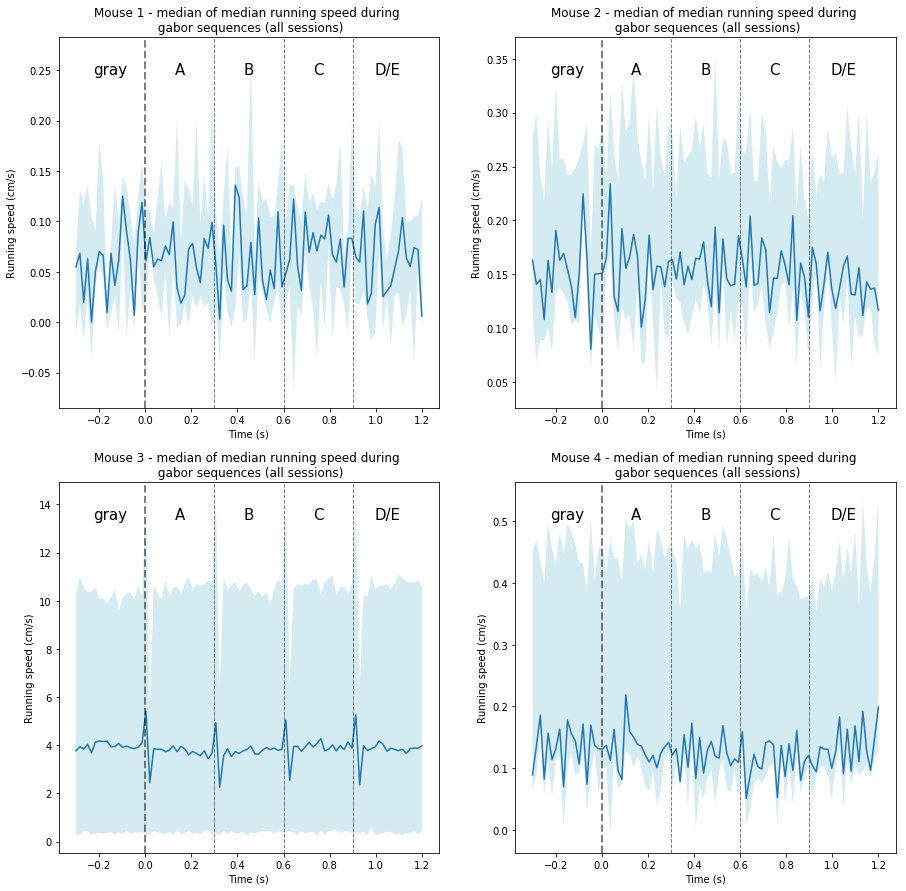

In [17]:
# plot median/mean running during gabor chunks throughout the sessions
rand=False
gab_chunks = []
for sesses in all_sess:
    sub_chunks = []
    for i, sess in enumerate(sesses):
        x_ran, run_chunks_me, _ = sess.gabors.get_run_chunk_stats(sess.gabors.get_A_frame_1s(by='frame'), 
                                                                     sess.gabors.pre, sess.gabors.post, rand=rand,
                                                                     stats=plot_stat)
        sub_chunks.append(np.asarray(run_chunks_me))
    gab_chunks.append(get_chunk_me_de(x_ran, sub_chunks, plot_stat))
    
# draw lines
h_bars = [0] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = np.linspace(-sess.gabors.pre,sess.gabors.post, 
                       num=sess.gabors.n_seg_per_set+2)[1:-1].tolist()
labels = ['gray', 'A', 'B', 'C', 'D/E']
xpos = [-0.15, 0.15, 0.45, 0.75, 1.05]

# plot
fig_gabA_all, ax_gabA_all = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gabA_all[i/2][i%2], gab_chunks[i], stats=plot_stat,
                title='Mouse {0} - {1} of {1} running speed during \n gabor sequences (all sessions)'
                .format(i+1, plot_stat), 
                hbars=h_bars, bars=seg_bars, labels=labels, xpos=xpos, t_hei=0.9)
    
fig_gabA_all.savefig('{}/run_all_sessions_gabors.png'.format(figdir_run), bbox_inches='tight')

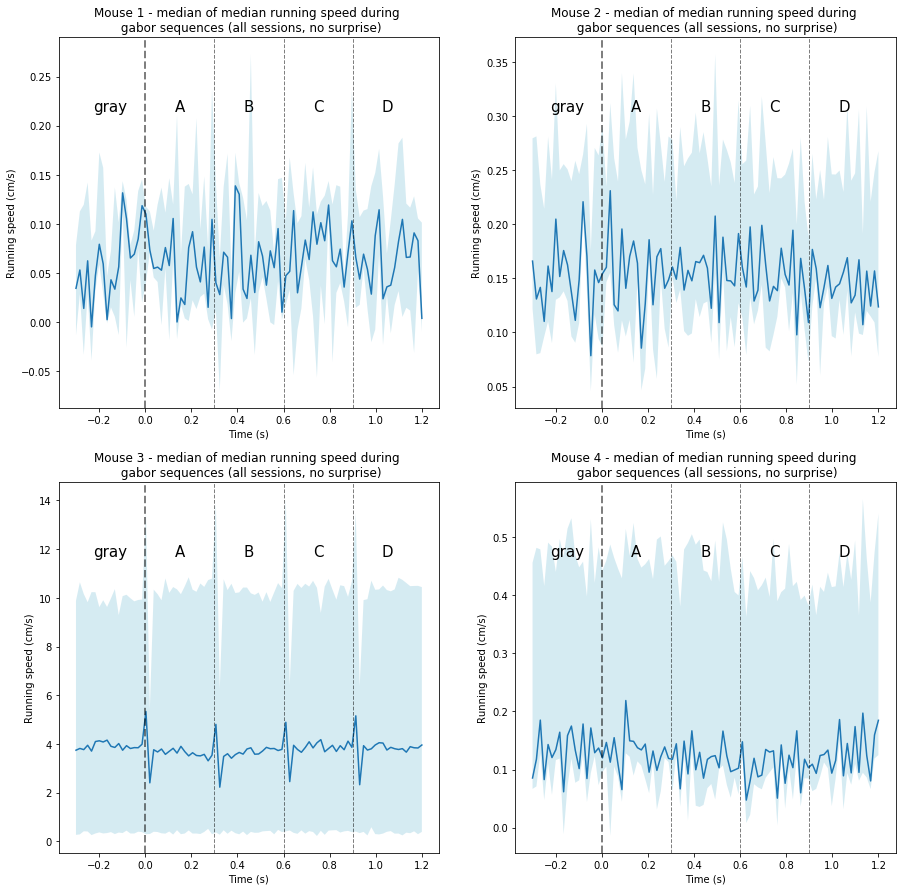

In [18]:
# plot average running during gabor chunks throughout the sessions (no_surp)
rand=False
gab_chunks = []
for sesses in all_sess:
    sub_chunks = []
    for i, sess in enumerate(sesses):
        data = sess.gabors.get_frames_by_criteria(gaborframe=0, surp=0, by='frame')
        x_ran, run_chunks_me, _ = sess.gabors.get_run_chunk_stats(data, sess.gabors.pre, 
                                                                  sess.gabors.post, rand=rand,
                                                                  stats=plot_stat)
        sub_chunks.append(np.asarray(run_chunks_me))
    gab_chunks.append(get_chunk_me_de(x_ran, sub_chunks, plot_stat))
    
# draw lines
h_bars = [0] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = np.linspace(-sess.gabors.pre,sess.gabors.post, 
                       num=sess.gabors.n_seg_per_set+2)[1:-1].tolist()
labels = ['gray', 'A', 'B', 'C', 'D']
xpos = [-0.15, 0.15, 0.45, 0.75, 1.05]

# plot
fig_gabA_nosurp, ax_gabA_nosurp = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gabA_nosurp[i/2][i%2], gab_chunks[i], stats=plot_stat,
                title='Mouse {0} - {1} of {1} running speed during \n gabor sequences (all sessions, no surprise)'
                .format(i+1, plot_stat), 
                hbars=h_bars, bars=seg_bars, labels=labels, xpos=xpos, t_hei=0.80)
    
fig_gabA_nosurp.savefig('{}/run_all_sessions_gabors_nosurp.png'.format(figdir_run), bbox_inches='tight')

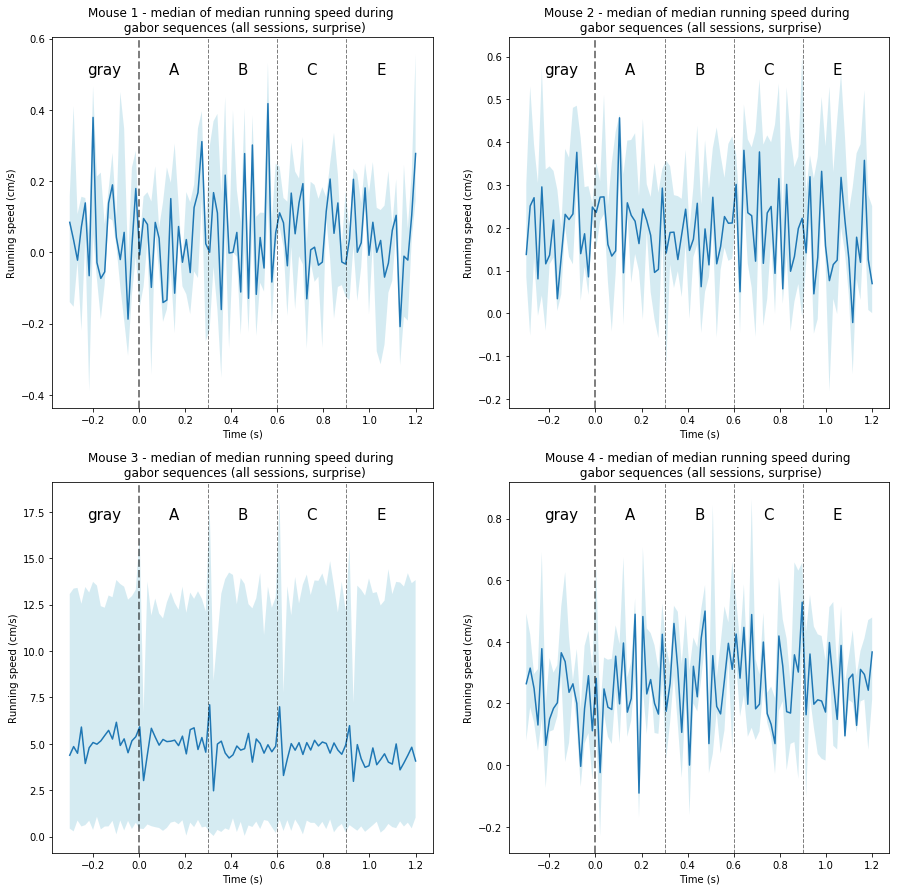

In [19]:
# plot average running during gabor chunks throughout the sessions (surp)
rand=False
gab_chunks = []
for sesses in all_sess:
    sub_chunks = []
    for i, sess in enumerate(sesses):
        data = sess.gabors.get_frames_by_criteria(gaborframe=0, surp=1, by='frame')
        x_ran, run_chunks_me, _ = sess.gabors.get_run_chunk_stats(data, sess.gabors.pre, 
                                                                  sess.gabors.post, rand=rand,
                                                                  stats=plot_stat)
        sub_chunks.append(np.asarray(run_chunks_me))
    gab_chunks.append(get_chunk_me_de(x_ran, sub_chunks, plot_stat))
    
# draw lines
h_bars = [0] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = np.linspace(-sess.gabors.pre,sess.gabors.post, 
                       num=sess.gabors.n_seg_per_set+2)[1:-1].tolist()
labels = ['gray', 'A', 'B', 'C', 'E']
xpos = [-0.15, 0.15, 0.45, 0.75, 1.05]

# plot
fig_gabA_surp, ax_gabA_surp = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gabA_surp[i/2][i%2], gab_chunks[i], stats=plot_stat,
                title='Mouse {0} - {1} of {1} running speed during \n gabor sequences (all sessions, surprise)'
                .format(i+1, plot_stat), 
                hbars=h_bars, bars=seg_bars, labels=labels, xpos=xpos, t_hei=0.90)
    
fig_gabA_surp.savefig('{}/run_all_sessions_gabors_surp.png'.format(figdir_run), bbox_inches='tight')

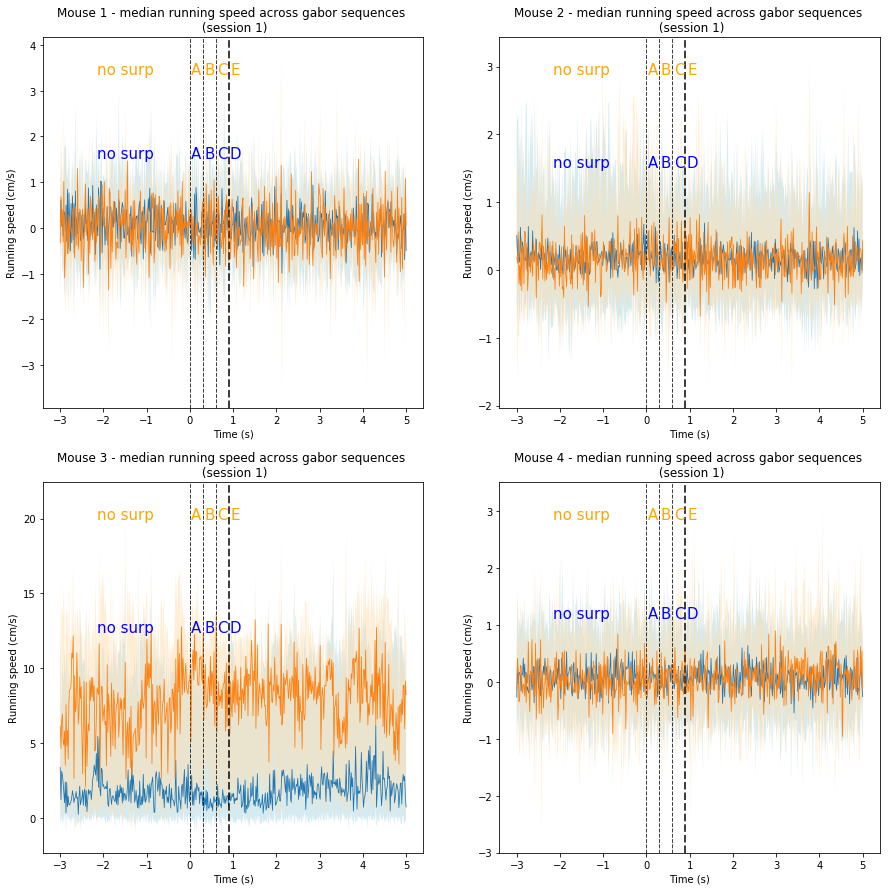

In [20]:
# plot running across gabor nosurp->nosurp vs nosurp->surp in first session
rand=False
pre=3
post=5
gab_st_surp_chunks = []
gab_no_surp_chunks = []
for i, sess in enumerate(first_sess):
    # start surp
    st_surp_seg = sess.gabors.get_frames_by_criteria(surp=1, remconsec=True, by='frame')
    gab_st_surp_chunks.append(sess.gabors.get_run_chunk_stats(st_surp_seg, pre, post, rand=rand, stats=plot_stat))
    # no surp
    no_surp_seg = sess.gabors.get_segs_by_criteria(surp=0, gaborframe=0, by='seg')
    rev = list(reversed(no_surp_seg))
    # get non surprise segs somewhat staggered, while preventing overlapping windows
    temp = []
    count=0
    min_set = np.ceil((pre+post+1)/sess.gabors.set_len_s)
    max_set = np.ceil(1.5*(pre+post)/sess.gabors.set_len_s)
    set_pre = np.ceil(pre/sess.gabors.set_len_s).astype(int)
    sep = np.random.choice(np.arange(min_set, max_set)) # get a set separation value
    for j, seg in enumerate(rev):
        if j >= len(rev)-set_pre:
            break
        elif j==0 or seg == rev[j+set_pre]+sess.gabors.n_seg_per_set*set_pre:
            if count == sep:
                temp.extend([seg])
                count=0
            else:
                count += 1
                sep = np.random.choice(np.arange(min_set, max_set)) # get a new value
        else:
            count=0
    no_surp_fr = [sess.gabors.frame_list.index(x) for x in list(reversed(temp))]
    gab_no_surp_chunks.append(sess.gabors.get_run_chunk_stats(no_surp_fr, pre, post, rand=rand, stats=plot_stat))
    
# draw lines
h_bars = [0.9] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = [0, 0.3, 0.6]
labels_1 = ['no surp', 'A', 'B', 'C', 'E']
labels_2 = ['no surp', 'A', 'B', 'C', 'D']
xpos = [-1.5, 0.15, 0.45, 0.75, 1.05]

# plot
fig_gab_surp_nosurp, ax_gab_surp_nosurp = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gab_surp_nosurp[i/2][i%2], gab_no_surp_chunks[i], stats=plot_stat,
                title='Mouse {} - {} running speed across gabor sequences \n (session 1)'
                .format(i+1, plot_stat),
                hbars=h_bars, bars=seg_bars, lw=0.8, labels=labels_2, xpos=xpos, t_hei=0.7, col='b')
    plot_chunks(ax_gab_surp_nosurp[i/2][i%2], gab_st_surp_chunks[i], stats=plot_stat,
                title='Mouse {} - {} running speed across gabor sequences \n (session 1)'
                .format(i+1, plot_stat), 
                hbars=h_bars, bars=seg_bars, lw=0.8, btwc='navajowhite', labels=labels_1, xpos=xpos, t_hei=0.9, col='orange')
fig_gab_surp_nosurp.savefig('{}/run_session_1_gabors_surp_nosurp.png'.format(figdir_run), bbox_inches='tight')

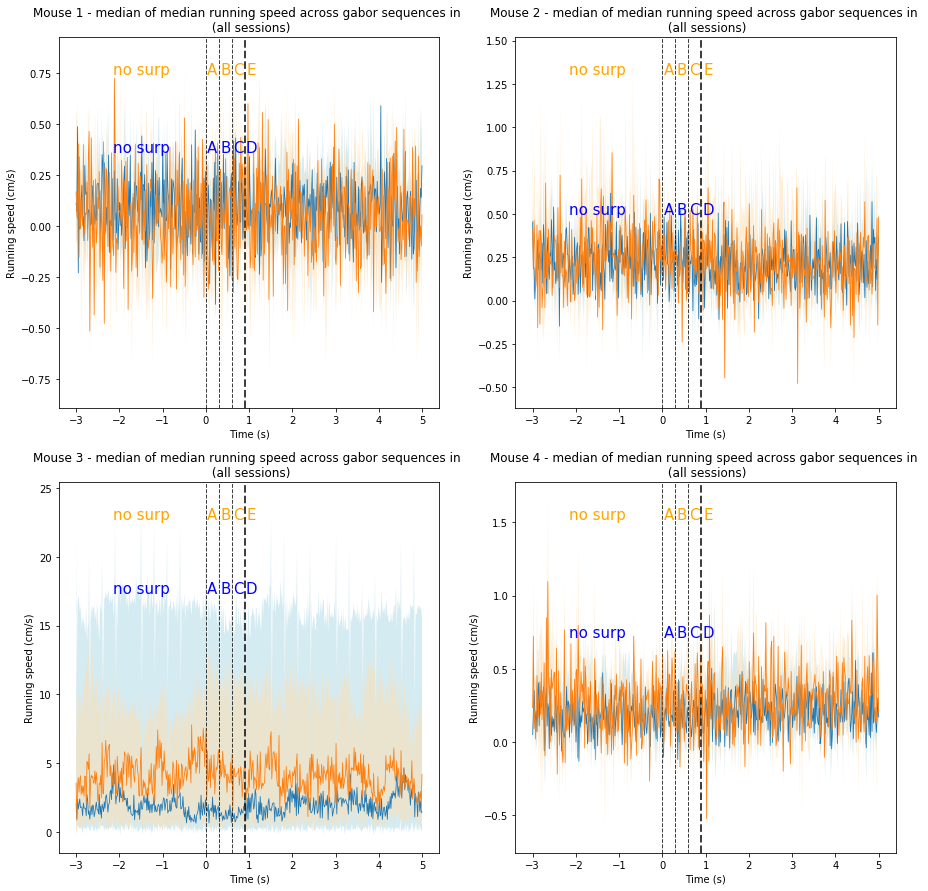

In [21]:
# plot average across gabor nosurp->nosurp vs nosurp->surp throughout the sessions
rand=False
pre=3
post=5
gab_st_surp_chunks = []
gab_no_surp_chunks = []
for sesses in all_sess:
    sub_chunks_st_surp = []
    sub_chunks_no_surp = []
    for i, sess in enumerate(sesses):
        # start surp
        data_st = sess.gabors.get_frames_by_criteria(surp=1, remconsec=True, by='frame')
        x_ran, run_chunks_me, _ = sess.gabors.get_run_chunk_stats(data_st, pre, post, rand=rand,
                                                                  stats=plot_stat)
        sub_chunks_st_surp.append(np.asarray(run_chunks_me))
        # no surp
        no_surp_seg = sess.gabors.get_segs_by_criteria(surp=0, gaborframe=0, by='seg')
        rev = list(reversed(no_surp_seg))
        # get non surprise segs somewhat staggered, while preventing overlapping windows
        temp = []
        count=0
        min_set = np.ceil((pre+post+1)/sess.gabors.set_len_s)
        max_set = np.ceil(1.5*(pre+post)/sess.gabors.set_len_s)
        set_pre = np.ceil(pre/sess.gabors.set_len_s).astype(int)
        sep = np.random.choice(np.arange(min_set, max_set)) # get a set separation value
        for j, seg in enumerate(rev):
            if j >= len(rev)-set_pre:
                break
            elif j==0 or seg == rev[j+set_pre]+sess.gabors.n_seg_per_set*set_pre:
                if count == sep:
                    temp.extend([seg])
                    count=0
                else:
                    count += 1
                    sep = np.random.choice(np.arange(min_set, max_set)) # get a new value
            else:
                count=0
        no_surp_fr = [sess.gabors.frame_list.index(x) for x in list(reversed(temp))]
        _, run_chunks_me, _ = sess.gabors.get_run_chunk_stats(no_surp_fr, pre, post, rand=rand,
                                                              stats=plot_stat)
        sub_chunks_no_surp.append(np.asarray(run_chunks_me))
    gab_st_surp_chunks.append(get_chunk_me_de(x_ran, sub_chunks_st_surp, plot_stat))
    gab_no_surp_chunks.append(get_chunk_me_de(x_ran, sub_chunks_no_surp, plot_stat))
    
# draw lines
h_bars = [0.9] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = [0, 0.3, 0.6]
labels_1 = ['no surp', 'A', 'B', 'C', 'E']
labels_2 = ['no surp', 'A', 'B', 'C', 'D']
xpos = [-1.5, 0.15, 0.45, 0.75, 1.05]

# plot
fig_gab_surp_nosurp_all, ax_gab_surp_nosurp_all = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gab_surp_nosurp_all[i/2][i%2], gab_no_surp_chunks[i], stats=plot_stat,
                title='Mouse {0} - {1} of {1} running speed across gabor sequences in \n (all sessions)'
                .format(i+1, plot_stat),
                hbars=h_bars, bars=seg_bars, lw=0.8, labels=labels_2, xpos=xpos, t_hei=0.7, col='b')
    plot_chunks(ax_gab_surp_nosurp_all[i/2][i%2], gab_st_surp_chunks[i], stats=plot_stat,
                title='Mouse {0} - {1} of {1} running speed across gabor sequences in \n (all sessions)'
                .format(i+1, plot_stat), 
                hbars=h_bars, bars=seg_bars, lw=0.8, btwc='navajowhite', labels=labels_1, xpos=xpos, t_hei=0.9, col='orange')
        
fig_gab_surp_nosurp_all.savefig('{}/run_all_sessions_gabors_surp_nosurp.png'.format(figdir_run), bbox_inches='tight')

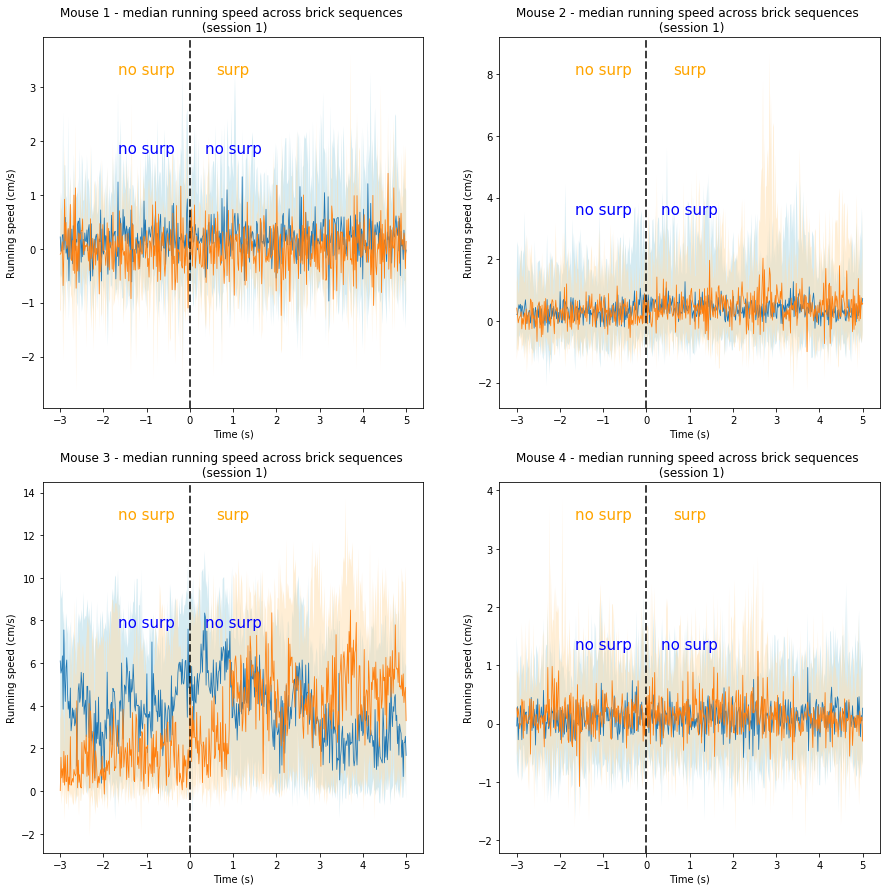

In [22]:
# plot running across bricks nosurp->nosurp vs nosurp->surp in first session
rand=False
pre=3
post=5
bri_st_surp_chunks = []
bri_no_surp_chunks = []
for i, sess in enumerate(first_sess):
    # start surp
    st_surp_seg = sess.bricks.get_frames_by_criteria(surp=1, remconsec=True, by='frame')
    bri_st_surp_chunks.append(sess.bricks.get_run_chunk_stats(st_surp_seg, pre, post, rand=rand, stats=plot_stat))
    # no surp
    no_surp_seg = sess.bricks.get_segs_by_criteria(surp=0, by='seg')
    rev = list(reversed(no_surp_seg))
    # get non surprise segs somewhat staggered, while preventing overlapping windows
    temp = []
    count=0
    min_seg = pre+post+1
    max_seg = 1.5*(pre+post)
    sep = np.random.choice(np.arange(min_seg, max_seg)) # get a set separation value
    for j, seg in enumerate(rev):
        if j >= len(rev)-pre:
            break
        elif j==0 or seg == rev[j+pre]+pre:
            if count == sep:
                temp.extend([seg])
                count=0
            else:
                count += 1
                sep = np.random.choice(np.arange(min_seg, max_seg)) # get a new value
        else:
            count=0
    no_surp_fr = [sess.bricks.frame_list.index(x) for x in list(reversed(temp))]
    bri_no_surp_chunks.append(sess.bricks.get_run_chunk_stats(no_surp_fr, pre, post, rand=rand, stats=plot_stat))
    
# draw lines
h_bars = [0] # heavy at 0
labels_1 = ['no surp', 'surp']
labels_2 = ['no surp', 'no surp']
xpos = [-1, 1]

# plot
fig_bri_surp_nosurp, ax_bri_surp_nosurp = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_bri_surp_nosurp[i/2][i%2], bri_no_surp_chunks[i], stats=plot_stat,
                title='Mouse {} - {} running speed across brick sequences \n (session 1)'
                .format(i+1, plot_stat),
                hbars=h_bars, lw=0.8, labels=labels_2, xpos=xpos, t_hei=0.7, col='b')
    plot_chunks(ax_bri_surp_nosurp[i/2][i%2], bri_st_surp_chunks[i], stats=plot_stat,
                title='Mouse {} - {} running speed across brick sequences \n (session 1)'
                .format(i+1, plot_stat), 
                hbars=h_bars, lw=0.8, btwc='navajowhite', labels=labels_1, xpos=xpos, t_hei=0.9, col='orange')
    
fig_bri_surp_nosurp.savefig('{}/run_session_1_bricks_surp_nosurp.png'.format(figdir_run), bbox_inches='tight')

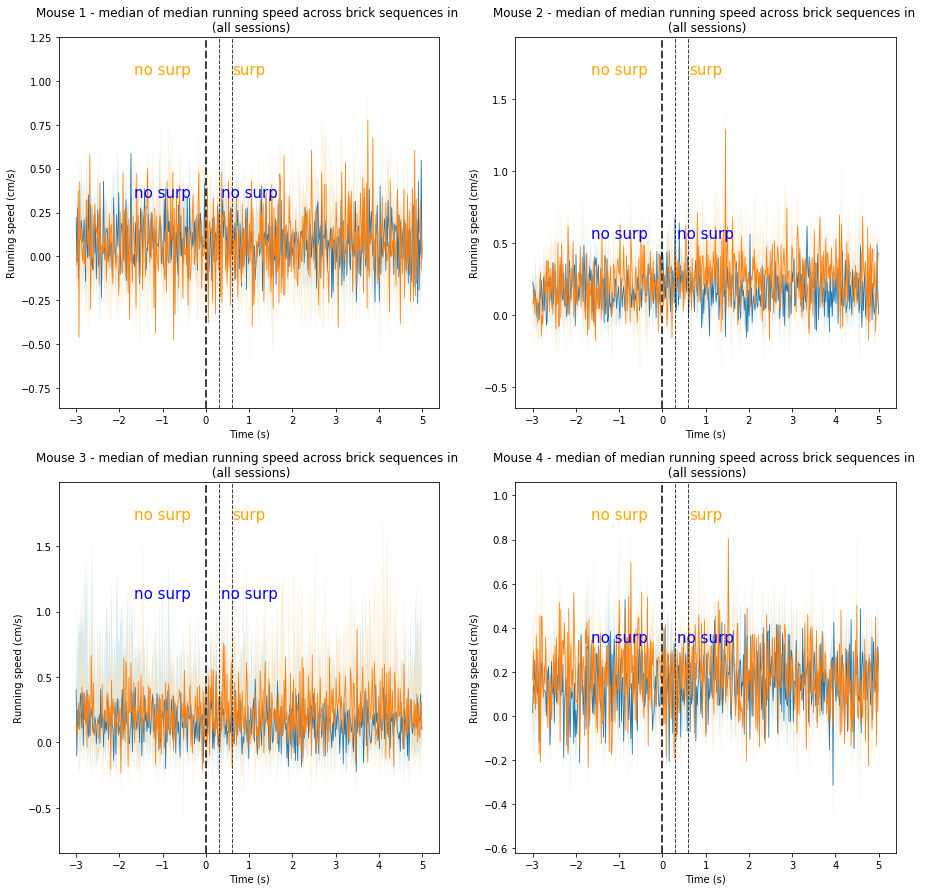

In [23]:
# plot average across bricks nosurp->nosurp vs nosurp->surp throughout the sessions
rand=False
pre=3
post=5
bri_st_surp_chunks = []
bri_no_surp_chunks = []
for sesses in all_sess:
    sub_chunks_st_surp = []
    sub_chunks_no_surp = []
    for i, sess in enumerate(sesses):
        # surp start
        data_st = sess.bricks.get_frames_by_criteria(surp=1, remconsec=True, by='frame')
        x_ran, run_chunks_me, _ = sess.bricks.get_run_chunk_stats(data_st, pre, post, rand=rand,
                                                                  stats=plot_stat)
        sub_chunks_st_surp.append(np.asarray(run_chunks_me))
        # no surp
        no_surp_seg = sess.bricks.get_segs_by_criteria(surp=0, by='seg')
        rev = list(reversed(no_surp_seg))
        # get non surprise segs somewhat staggered, while preventing overlapping windows
        temp = []
        count=0
        min_seg = pre+post+1
        max_seg = 1.5*(pre+post)
        sep = np.random.choice(np.arange(min_seg, max_seg)) # get a set separation value
        for j, seg in enumerate(rev):
            if j >= len(rev)-pre:
                break
            elif j==0 or seg == rev[j+pre]+pre:
                if count == sep:
                    temp.extend([seg])
                    count=0
                else:
                    count += 1
                    sep = np.random.choice(np.arange(min_seg, max_seg)) # get a new value
            else:
                count=0
                no_surp_fr = [sess.bricks.frame_list.index(x) for x in list(reversed(temp))]
        _, run_chunks_me, _ = sess.bricks.get_run_chunk_stats(no_surp_fr, pre, post, rand=rand,
                                                              stats=plot_stat)
        sub_chunks_no_surp.append(np.asarray(run_chunks_me))
    bri_st_surp_chunks.append(get_chunk_me_de(x_ran, sub_chunks_st_surp, plot_stat))
    bri_no_surp_chunks.append(get_chunk_me_de(x_ran, sub_chunks_no_surp, plot_stat))
    
# draw lines
h_bars = [0] # heavy at 0
labels_1 = ['no surp', 'surp']
labels_2 = ['no surp', 'no surp']
xpos = [-1, 1]

# plot
fig_bri_surp_nosurp_all, ax_bri_surp_nosurp_all = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_bri_surp_nosurp_all[i/2][i%2], bri_no_surp_chunks[i], stats=plot_stat,
                title='Mouse {0} - {1} of {1} running speed across brick sequences in \n (all sessions)'
                .format(i+1, plot_stat),
                hbars=h_bars, bars=seg_bars, lw=0.8, labels=labels_2, xpos=xpos, t_hei=0.7, col='b')
    plot_chunks(ax_bri_surp_nosurp_all[i/2][i%2], bri_st_surp_chunks[i], stats=plot_stat,
                title='Mouse {0} - {1} of {1} running speed across brick sequences in \n (all sessions)'
                .format(i+1, plot_stat), 
                hbars=h_bars, bars=seg_bars, lw=0.8, btwc='navajowhite', labels=labels_1, xpos=xpos, t_hei=0.9, col='orange')
fig_bri_surp_nosurp_all.savefig('{}/run_all_sessions_bricks_surp_nosurp.png'.format(figdir_run), bbox_inches='tight')

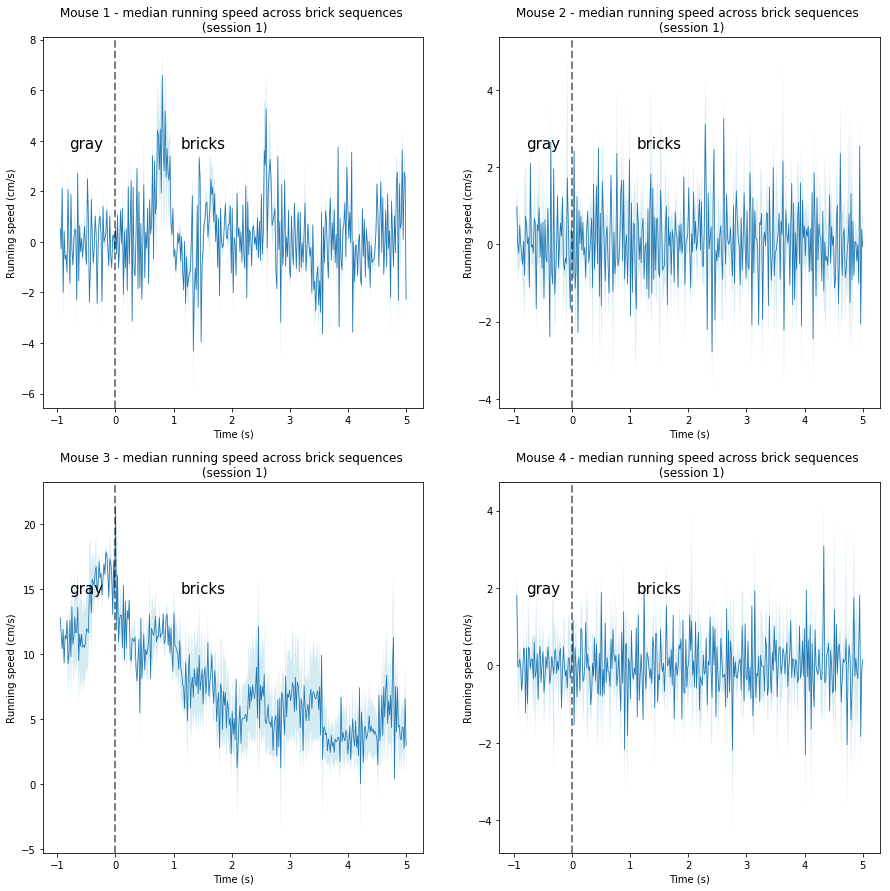

In [24]:
# pre post running for grayscr -> bricks
rand=False
pre=0.95
post=5
bri_st_chunks = []
for i, sess in enumerate(first_sess):
    bri_st = [i[0] for j in sess.bricks.block_ran_fr for i in j]
    bri_st_chunks.append(sess.bricks.get_run_chunk_stats(bri_st, pre, post, rand=rand, stats=plot_stat))
    
# draw lines
h_bars = [0] # heavy at 0
labels = ['gray', 'bricks']
xpos = [-0.5, 1.5]

# plot
fig_gray2bri, ax_gray2bri = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gray2bri[i/2][i%2], bri_st_chunks[i], stats=plot_stat,
                title='Mouse {} - {} running speed across brick sequences \n (session 1)'
                .format(i+1, plot_stat),
                hbars=h_bars, lw=0.8, labels=labels, xpos=xpos, t_hei=0.7)
    
fig_gray2bri.savefig('{}/run_session_1_gray_to_bri.png'.format(figdir_run), bbox_inches='tight')


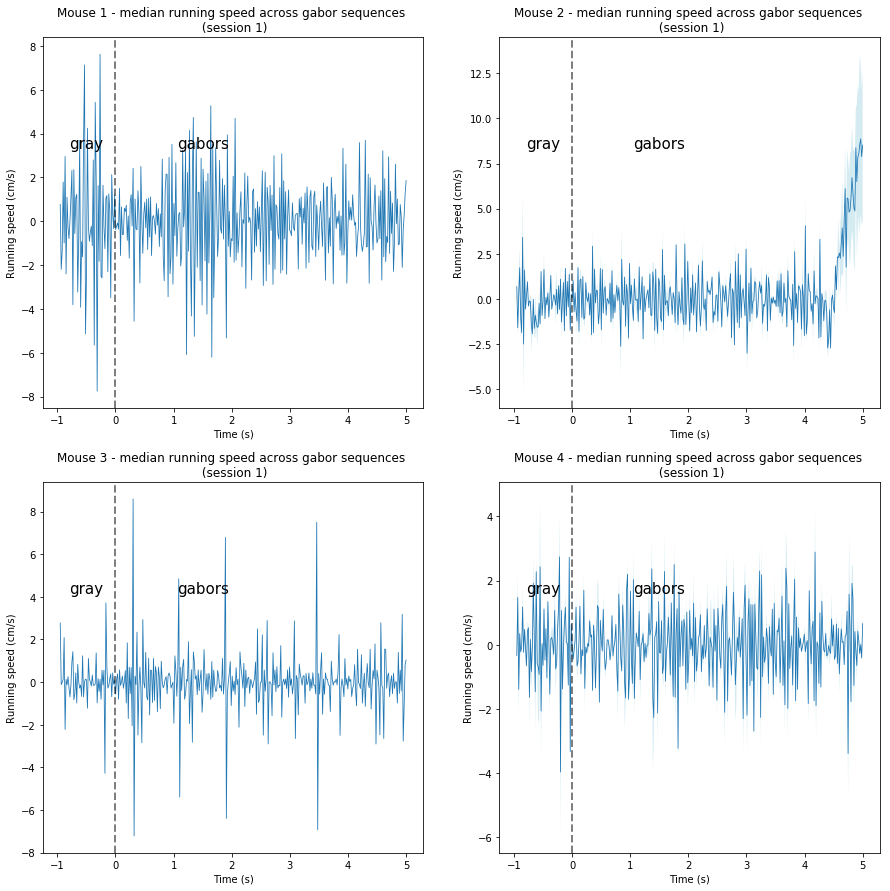

In [25]:
# pre post running for grayscr -> gabors
rand=False
pre=0.95
post=5
gab_st_chunks = []
for i, sess in enumerate(first_sess):
    gab_st = [i[0] for j in sess.gabors.block_ran_fr for i in j]
    gab_st_chunks.append(sess.gabors.get_run_chunk_stats(gab_st, pre, post, rand=rand, stats=plot_stat))
    
# draw lines
h_bars = [0] # heavy at 0
labels = ['gray', 'gabors']
xpos = [-0.5, 1.5]

# plot
fig_gray2gab, ax_gray2gab = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gray2gab[i/2][i%2], gab_st_chunks[i], stats=plot_stat,
                title='Mouse {} - {} running speed across gabor sequences \n (session 1)'
                .format(i+1, plot_stat),
                hbars=h_bars, lw=0.8, labels=labels, xpos=xpos, t_hei=0.7)
    
fig_gray2gab.savefig('{}/run_session_1_gray_to_gab.png'.format(figdir_run), bbox_inches='tight')


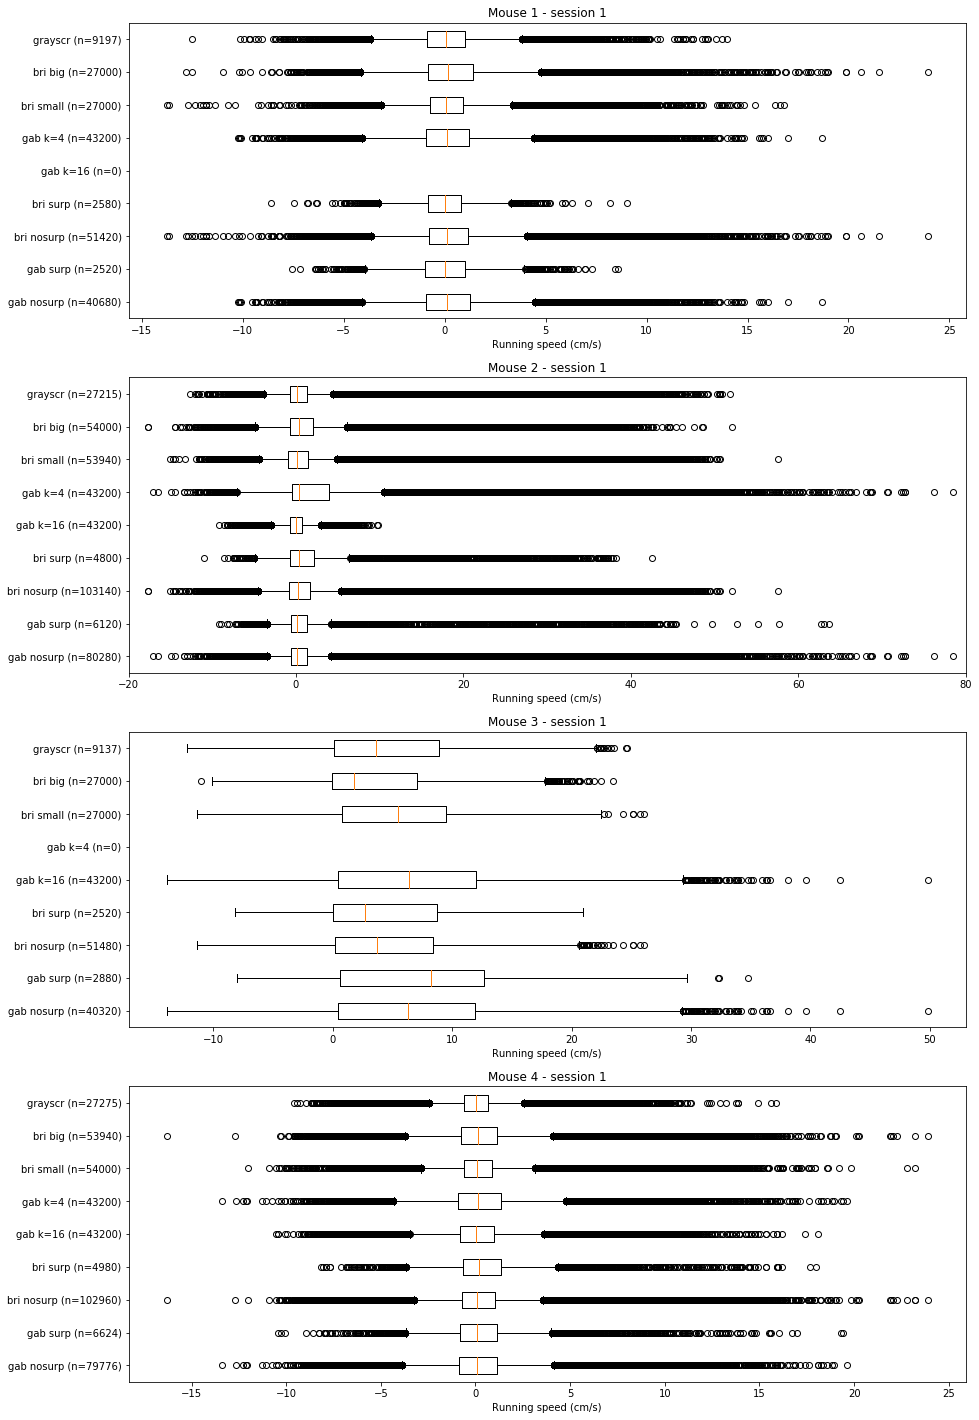

In [26]:
# all stats
# NOTE: Gabor surprise data not as interesting as it's so short and only frame 3 is surprising
all_data = []
for sess in first_sess:
    gab_surp_run, gab_nosurp_run = [sess.run[x] for x in sess.gabors.get_all_surp_frames(by='frame')] # excludes grayscr
    bri_surp_run, bri_nosurp_run = [sess.run[x] for x in sess.bricks.get_all_surp_frames(by='frame')] # excludes grayscr
    gray_run = sess.run[sess.grayscr.get_all_nongab_frames()]
    try:
        gab_run_16 = sess.run[sess.gabors.get_frames_by_criteria(stimPar2=16, first_fr=False, by='frame')] # excludes grayscr
    except:
        gab_run_16 = []
    try:
        gab_run_4 = sess.run[sess.gabors.get_frames_by_criteria(stimPar2=4, first_fr=False, by='frame')] # excludes grayscr
    except:
        gab_run_4 = []
    try:
        bri_run_small = sess.run[sess.bricks.get_frames_by_criteria(stimPar1=256, first_fr=False, by='frame')] # excludes grayscr
    except:
        bri_run_small = []
    try:
        bri_run_big = sess.run[sess.bricks.get_frames_by_criteria(stimPar1=128, first_fr=False, by='frame')] # excludes grayscr
    except:
        bri_run_big = []
    all_data.append([gab_nosurp_run, gab_surp_run, bri_nosurp_run, bri_surp_run, gab_run_16, gab_run_4,
                    bri_run_small, bri_run_big, gray_run])

# CHECK ORDER!!!
label_surp = ['gab nosurp', 'gab surp', 'bri nosurp', 'bri surp', 'gab k=16', 'gab k=4', 'bri small', 'bri big', 'grayscr']


# boxplots of data
fig_box, ax_box = plt.subplots(nrows=4, figsize=(15, 25))
titles = ['Mouse {} - session 1'.format(i+1) for i in range(n_mice)]
for i in range(n_mice):
    box_labels = ['{} (n={})'.format(lab, len(data)) for lab, data in zip(label_surp, all_data[i])]
    ax_box[i].boxplot(all_data[i], vert=False)
    if i == 1: # get rid of outlier
        ax_box[i].set_xlim(-20, 80)
    ax_box[i].set_title(titles[i])
    ax_box[i].set_xlabel('Running speed (cm/s)')
    ax_box[i].set_yticklabels(box_labels)

fig_box.savefig('{}/run_session_1_stats.png'.format(figdir_run), bbox_inches='tight')

In [47]:
def get_autocorr(stim, lag_s, val=None, fps=None, rand=False):
    # autocorrelation function
    if fps is None:
        lag_f = int(stim.stim_fps * lag_s)
    else:
        lag_f = int(fps * lag_s)

    autocorr_snips = []
    autocorr_rand_snips = []

    # flat list of blocks ranges in frames
    if val is None:
        run_bybl = stim.get_run(by='block')
    else:
        run_bybl = val
    for i in run_bybl:
        norm_values = i - np.mean(i)
        # get autocorrelation snip
        autocorr = np.correlate(norm_values, norm_values, 'full')

        # autocorr will always produce an odd length, so this should 
        # always give an integer
        mid = int((autocorr.shape[0]-1)/2) 
        autocorr_snip = autocorr[mid-lag_f:mid+lag_f]

        # deep copy normalized values and randomize
        norm_rand_values = norm_values[:]
        np.random.shuffle(norm_rand_values)
        autocorr_snip_rand = np.correlate(norm_rand_values, norm_rand_values, 'full')[mid-lag_f:mid+lag_f]

        # record normalized, snipped autocorrelations
        autocorr_snips.append((autocorr_snip/np.max(autocorr_snip)).tolist())
        autocorr_rand_snips.append((autocorr_snip_rand/np.max(autocorr_snip_rand)).tolist())

    # average autocorrelations for each lag across blocks
    autocorr_mean = [float(sum(col))/len(col) for col in zip(*autocorr_snips)]
    autocorr_rand_mean = [float(sum(col))/len(col) for col in zip(*autocorr_rand_snips)]

    x_auto_ran = np.linspace(-lag_s, lag_s, 2*lag_f)
    
    if not rand:
        return x_auto_ran, autocorr_mean
    if rand:
        return x_auto_ran, autocorr_mean, autocorr_rand_mean

In [48]:
def plot_autocorr(ax, autocorr, lag_s, stimname, rand=False, hbars=None, bars=None, lw=1.5, title=''):
    ax.plot(autocorr[0], autocorr[1], lw=lw)
    thickness = [2, 1]
    torem = []
    for i, j in enumerate([hbars, bars]):
        if j is not None:
            if not isinstance(j, list):
                j = [j]
            if i == 0:
                torem = j
            if i == 1:
                for r in torem:
                    if r in j:
                        j.remove(r)
            for k in j:
                ax.axvline(x=k, ls='dashed', c='k', lw='{}'
                           .format(thickness[i]), alpha=0.5)    
    ax.set_title(title)
    ax.set_xticks(np.arange(-lag_s, lag_s, lag_s/5.))
    ax.set_yticks(np.arange(0, 1, 0.2))

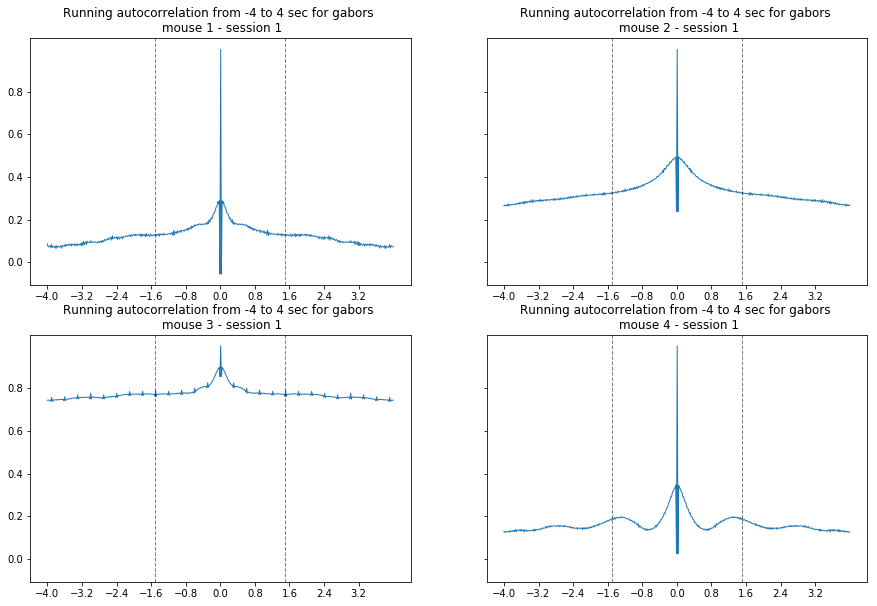

In [49]:
# plot running autocorrelation for gabors around desired lag (in s) (averaged by block) for session 1
lag_s=4
rand=False
gab_lines = [-1.5, 1.5]

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess):
    title = 'Running autocorrelation from -{} to {} sec for gabors \n mouse {} - session 1'.format(lag_s, lag_s, i+1)
    plot_autocorr(ax_gab_autocorr[i/2][i%2], get_autocorr(sess.gabors, lag_s=lag_s, rand=rand), lag_s, 
                 'gabors', rand=rand, bars=gab_lines, lw=1, title=title)
    
fig_gabautocorr.savefig('{}/run_session_1_gab_autocorr.png'.format(figdir_run), bbox_inches='tight')
    

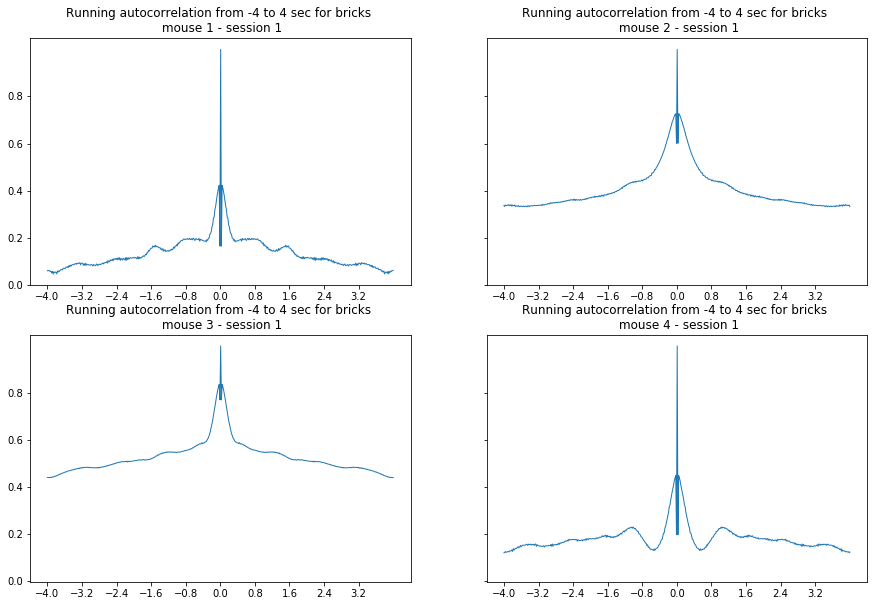

In [50]:
# plot running autocorrelation for bricks around desired lag (in s) (averaged by block) for session 1
lag_s=4
rand=False

fig_briautocorr, ax_bri_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess):
    title = 'Running autocorrelation from -{} to {} sec for bricks \n mouse {} - session 1'.format(lag_s, lag_s, i+1)
    plot_autocorr(ax_bri_autocorr[i/2][i%2], get_autocorr(sess.bricks, lag_s=lag_s, rand=rand), lag_s, 
                 'gabors', rand=rand, lw=1, title=title)
    
fig_briautocorr.savefig('{}/run_session_1_bri_autocorr.png'.format(figdir_run), bbox_inches='tight')
    

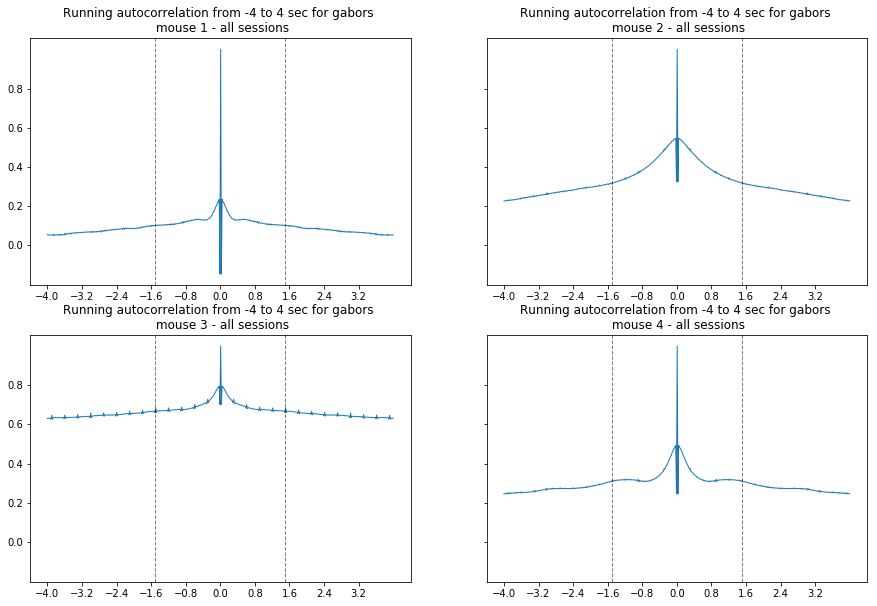

In [53]:
# plot running autocorrelation for gabors around desired lag (in s) (averaged by block) for all sessions
lag_s=4
rand=False
gab_lines = [-1.5, 1.5]

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sesses in enumerate(all_sess):
    title = 'Running autocorrelation from -{} to {} sec for gabors \n mouse {} - all sessions'.format(lag_s, lag_s, i+1)
    autocorrs = []
    for sess in sesses:
        autocorrs.append(np.asarray(get_autocorr(sess.gabors, lag_s=lag_s, rand=rand)))
    autocorr_av = np.mean(np.asarray(autocorrs), axis=0)
    plot_autocorr(ax_gab_autocorr[i/2][i%2], autocorr_av, lag_s, 
                 'gabors', rand=rand, bars=gab_lines, lw=1, title=title)
    
fig_gabautocorr.savefig('{}/run_all_sessions_gab_autocorr.png'.format(figdir_run), bbox_inches='tight')
    

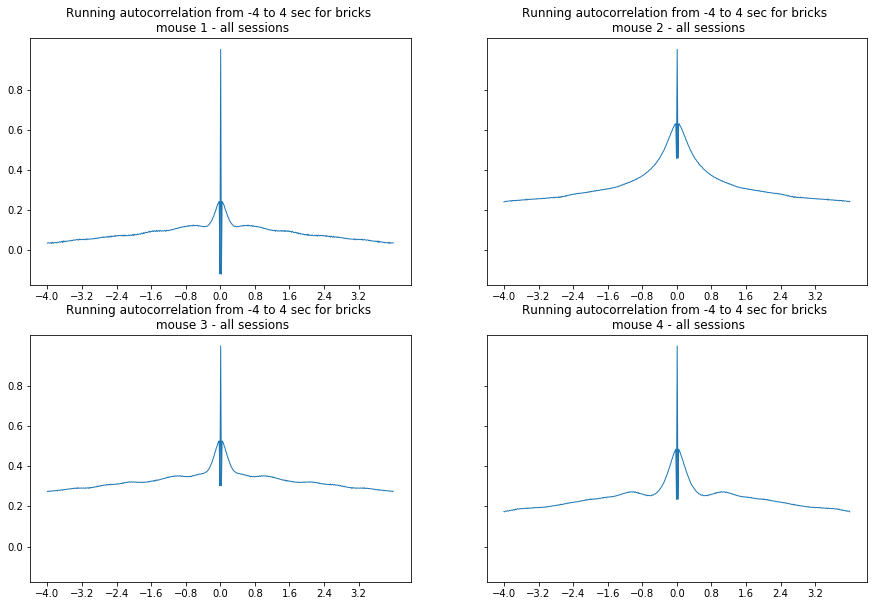

In [54]:
# plot running autocorrelation for bricks around desired lag (in s) (averaged by block) for all sessions
lag_s=4
rand=False

fig_briautocorr, ax_bri_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sesses in enumerate(all_sess):
    title = 'Running autocorrelation from -{} to {} sec for bricks \n mouse {} - all sessions'.format(lag_s, lag_s, i+1)
    autocorrs = []
    for sess in sesses:
        autocorrs.append(np.asarray(get_autocorr(sess.bricks, lag_s=lag_s, rand=rand)))
    autocorr_av = np.mean(np.asarray(autocorrs), axis=0)
    plot_autocorr(ax_bri_autocorr[i/2][i%2], autocorr_av, lag_s, 
                 'gabors', rand=rand, lw=1, title=title)
    
fig_briautocorr.savefig('{}/run_all_sessions_bri_autocorr.png'.format(figdir_run), bbox_inches='tight')
    

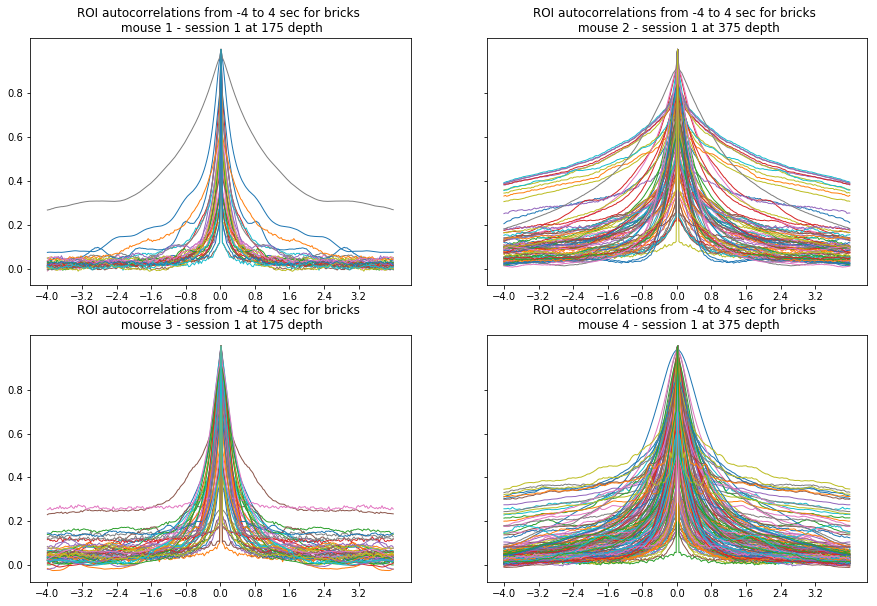

In [56]:
# plot ROI autocorrelation for bricks at low depth around desired lag (in s) (averaged by block) for session 1
lag_s=4
rand=False

fig_briautocorr, ax_bri_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_lo):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_lo_n[i])]['depth'].tolist()[0]
    blocks = [bl for disp in sess.bricks.block_ran_seg for bl in disp]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.bricks.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.bricks.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for bricks '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, i+1, depth))
        plot_autocorr(ax_bri_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'bricks', rand=rand, lw=1, title=title)
    
    
fig_briautocorr.savefig('{}/roi_session_1_bri_autocorr_lo.png'.format(figdir_roi), bbox_inches='tight')
    

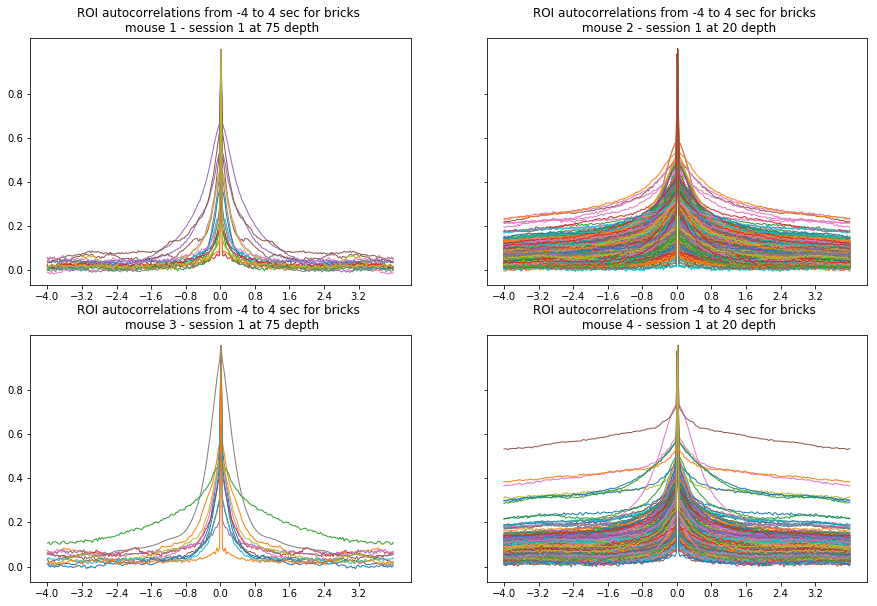

In [57]:
# plot ROI autocorrelation for bricks at high depth around desired lag (in s) (averaged by block) for session 1
lag_s=4
rand=False

fig_briautocorr, ax_bri_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_hi):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_hi_n[i])]['depth'].tolist()[0]
    blocks = [bl for disp in sess.bricks.block_ran_seg for bl in disp]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.bricks.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.bricks.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for bricks '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, i+1, depth))
        plot_autocorr(ax_bri_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'bricks', rand=rand, lw=1, title=title)
    
    
fig_briautocorr.savefig('{}/roi_session_1_bri_autocorr_hi.png'.format(figdir_roi), bbox_inches='tight')
    

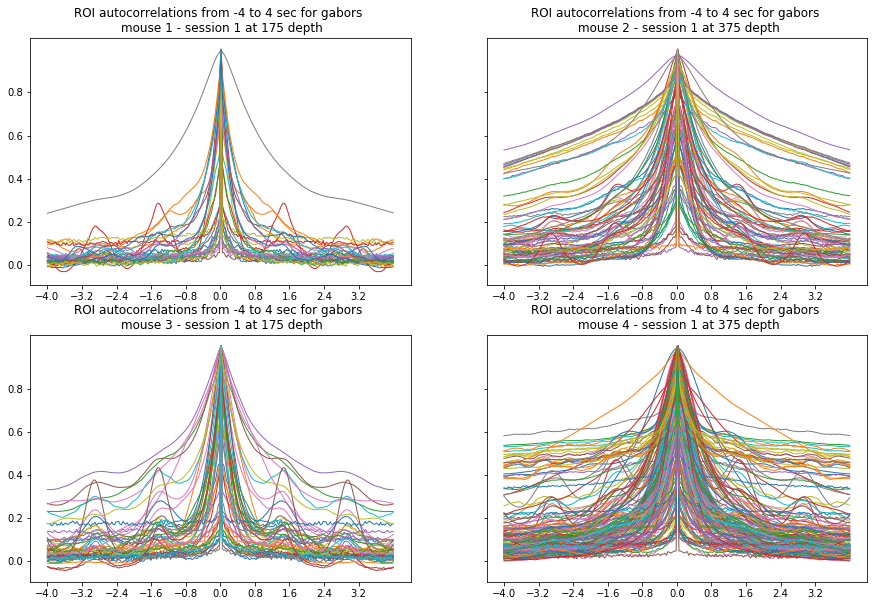

In [58]:
# plot ROI autocorrelation for gabors at low depth around desired lag (in s) (averaged by block) for session 1
lag_s=4
rand=False

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_lo):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_lo_n[i])]['depth'].tolist()[0]
    blocks = [bl for disp in sess.gabors.block_ran_seg for bl in disp]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for gabors '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, i+1, depth))
        plot_autocorr(ax_gab_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'gabors', rand=rand, lw=1, title=title)
    
    
fig_gabautocorr.savefig('{}/roi_session_1_gab_autocorr_lo.png'.format(figdir_roi), bbox_inches='tight')
    

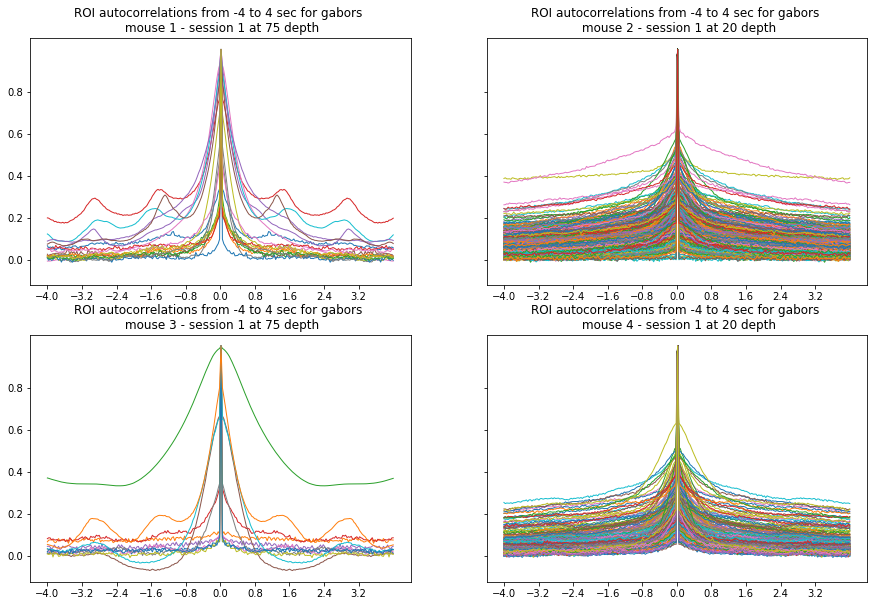

In [59]:
# plot ROI autocorrelation for gabors at high depth around desired lag (in s) (averaged by block) for session 1
lag_s=4
rand=False

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_hi):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_hi_n[i])]['depth'].tolist()[0]
    blocks = [bl for disp in sess.gabors.block_ran_seg for bl in disp]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for gabors '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, i+1, depth))
        plot_autocorr(ax_gab_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'gabors', rand=rand, lw=1, title=title)
    
    
fig_gabautocorr.savefig('{}/roi_session_1_gab_autocorr_hi.png'.format(figdir_roi), bbox_inches='tight')
    

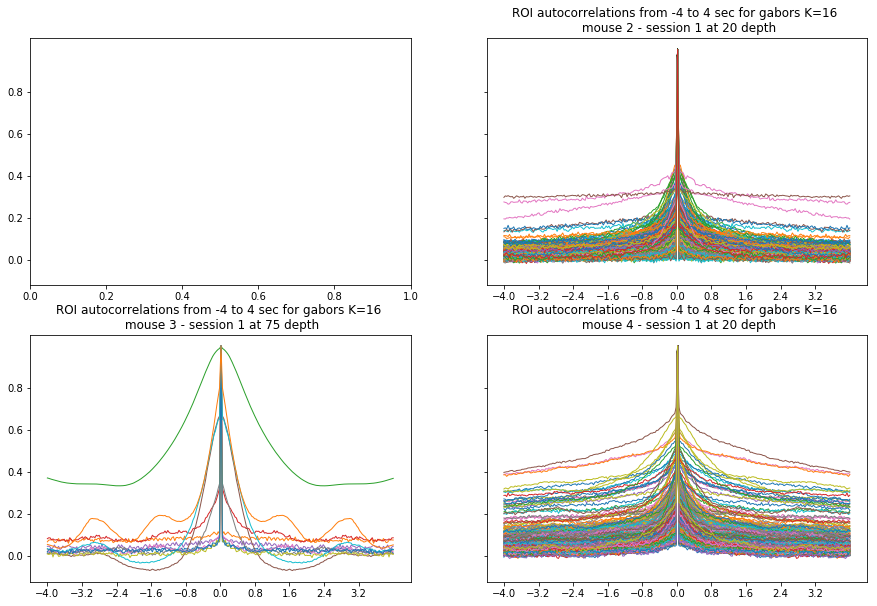

In [60]:
# plot ROI autocorrelation for gabors at high depth around desired lag (in s) (averaged by block) for K=16 for session 1
lag_s=4
rand=False

K = 16

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_hi):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_hi_n[i])]['depth'].tolist()[0]
    stimPar = sess.gabors.block_params
    blocks = [bl for dispb, dispp in zip(sess.gabors.block_ran_seg, sess.gabors.block_params) 
              for bl, p in zip(dispb, dispp) if p == K]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for gabors K={} '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, K, i+1, depth))
        plot_autocorr(ax_gab_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'gabors', rand=rand, lw=1, title=title)
    
    
fig_gabautocorr.savefig('{}/roi_session_1_gab16_autocorr_hi.png'.format(figdir_roi), bbox_inches='tight')
    

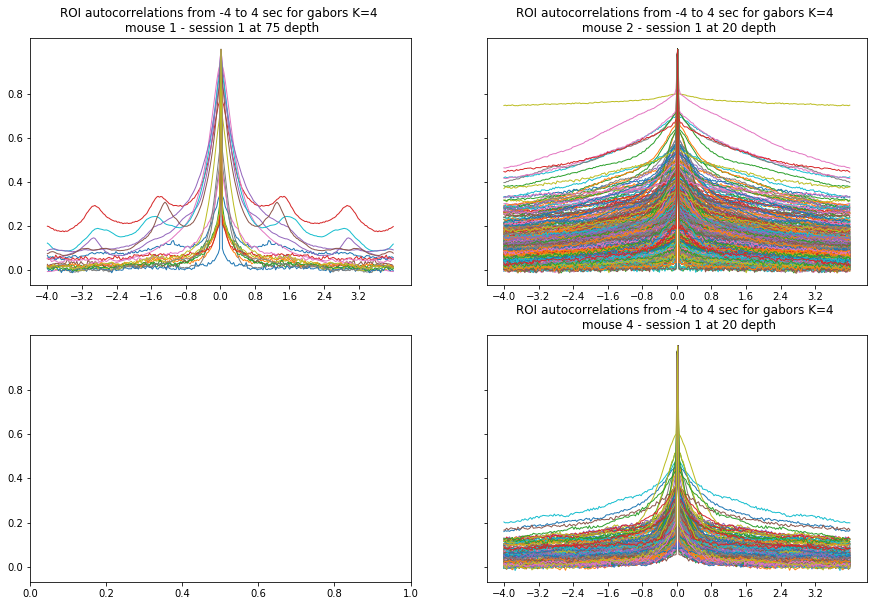

In [61]:
# plot ROI autocorrelation for gabors at high depth around desired lag (in s) (averaged by block) for K=4 for session 1
lag_s=4
rand=False

K = 4

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_hi):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_hi_n[i])]['depth'].tolist()[0]
    stimPar = sess.gabors.block_params
    blocks = [bl for dispb, dispp in zip(sess.gabors.block_ran_seg, sess.gabors.block_params) 
              for bl, p in zip(dispb, dispp) if p == K]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for gabors K={} '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, K, i+1, depth))
        plot_autocorr(ax_gab_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'gabors', rand=rand, lw=1, title=title)
    
    
fig_gabautocorr.savefig('{}/roi_session_1_gab16_autocorr_hi.png'.format(figdir_roi), bbox_inches='tight')
    

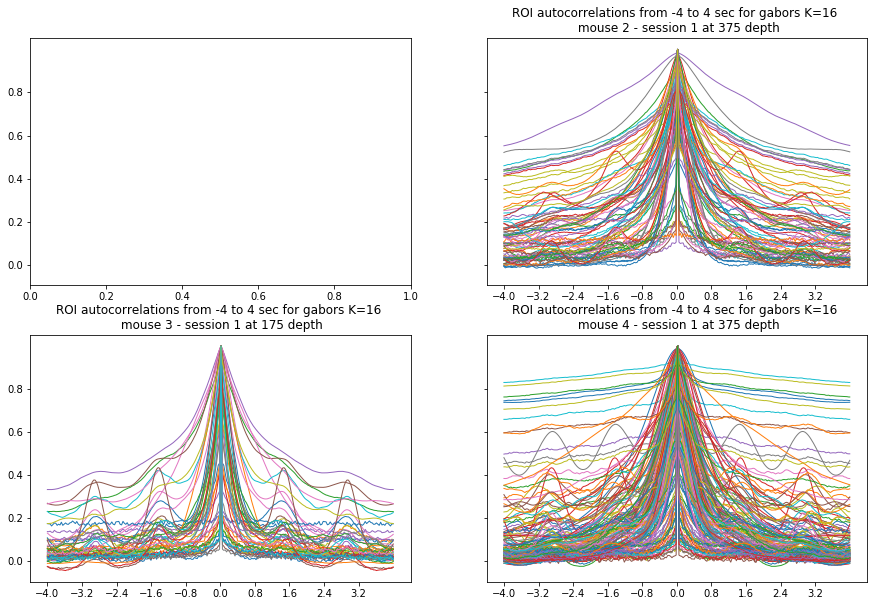

In [62]:
# plot ROI autocorrelation for gabors at low depth around desired lag (in s) (averaged by block) for K=16 for session 1
lag_s=4
rand=False

K = 16

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_lo):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_lo_n[i])]['depth'].tolist()[0]
    stimPar = sess.gabors.block_params
    blocks = [bl for dispb, dispp in zip(sess.gabors.block_ran_seg, sess.gabors.block_params) 
              for bl, p in zip(dispb, dispp) if p == K]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for gabors K={} '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, K, i+1, depth))
        plot_autocorr(ax_gab_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'gabors', rand=rand, lw=1, title=title)
    
    
fig_gabautocorr.savefig('{}/roi_session_1_gab4_autocorr_hi.png'.format(figdir_roi), bbox_inches='tight')
    

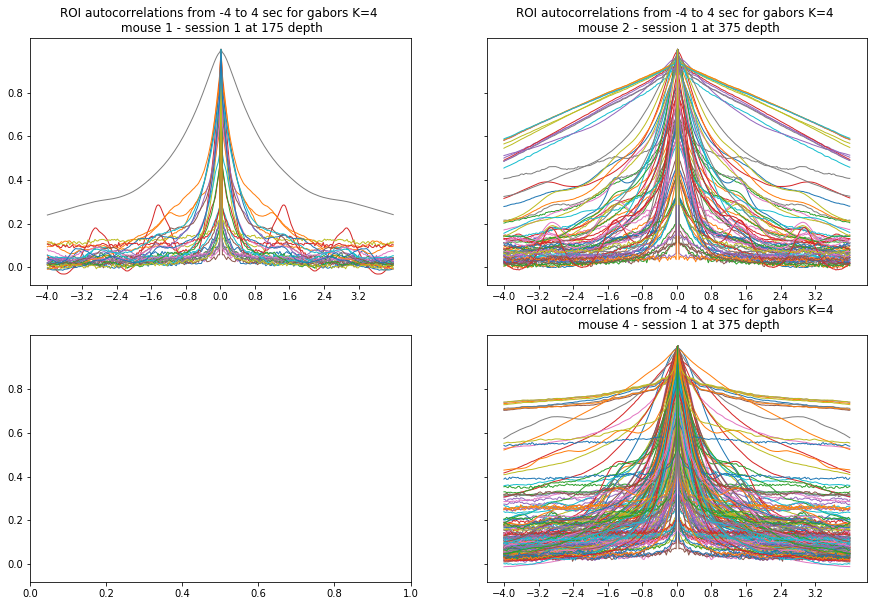

In [63]:
# plot ROI autocorrelation for gabors at low depth around desired lag (in s) (averaged by block) for K=4 for session 1
lag_s=4
rand=False

K = 4

fig_gabautocorr, ax_gab_autocorr = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10))
for i, sess in enumerate(first_sess_lo):
    depth = mouse_df.loc[(mouse_df['sessionid']==first_sess_lo_n[i])]['depth'].tolist()[0]
    stimPar = sess.gabors.block_params
    blocks = [bl for dispb, dispp in zip(sess.gabors.block_ran_seg, sess.gabors.block_params) 
              for bl, p in zip(dispb, dispp) if p == K]
    traces = []
    for n, j in enumerate(blocks):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces.append(sess.get_roi_traces(range(start, end)).tolist())
    traces = zip(*traces)
    for j in range(len(traces)):
        title = ('ROI autocorrelations from -{} to {} sec for gabors K={} '
                 '\n mouse {} - session 1 at {} depth'.format(lag_s, lag_s, K, i+1, depth))
        plot_autocorr(ax_gab_autocorr[i/2][i%2], get_autocorr(stim=None, lag_s=lag_s, val=traces[j], fps=31, rand=rand), lag_s, 
                     'gabors', rand=rand, lw=1, title=title)
    
    
fig_gabautocorr.savefig('{}/roi_session_1_gab4_autocorr_hi.png'.format(figdir_roi), bbox_inches='tight')
    

In [64]:
# average autocorrelation for gabors K=4 vs K=16

lag_s=4
rand=False

autocorr_4 = []
autocorr_16 = [] 
for sess in (first_sess_lo + first_sess_hi):
    stimPar = sess.gabors.block_params
    blocks_4 = [bl for dispb, dispp in zip(sess.gabors.block_ran_seg, sess.gabors.block_params) 
               for bl, p in zip(dispb, dispp) if p == 4]
    blocks_16 = [bl for dispb, dispp in zip(sess.gabors.block_ran_seg, sess.gabors.block_params) 
               for bl, p in zip(dispb, dispp) if p == 16]
    for n, j in enumerate(blocks_4):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces_4 = sess.get_roi_traces(range(start, end)).tolist()
        for j in range(len(traces_4)):
            autocorr_4.append(np.asarray(get_autocorr(stim=None, lag_s=lag_s, val=[traces_4[j]], fps=31, rand=rand))[1])
    for n, j in enumerate(blocks_16):
        start = sess.gabors.get_2pframes_by_seg([j[0]])[0][0]
        end = sess.gabors.get_2pframes_by_seg([j[1]-1])[0][-1]
        traces_16 = sess.get_roi_traces(range(start, end)).tolist()
        for j in range(len(traces_16)):
            autocorr_16.append(np.asarray(get_autocorr(stim=None, lag_s=lag_s, val=[traces_16[j]], fps=31, rand=rand))[1])
x_ran = np.asarray(get_autocorr(stim=None, lag_s=lag_s, val=[traces_16[j]], fps=31, rand=rand)[0])

autocorr_4 = np.asarray(autocorr_4) # ROI x autocorr_len
autocorr_16 = np.asarray(autocorr_16)

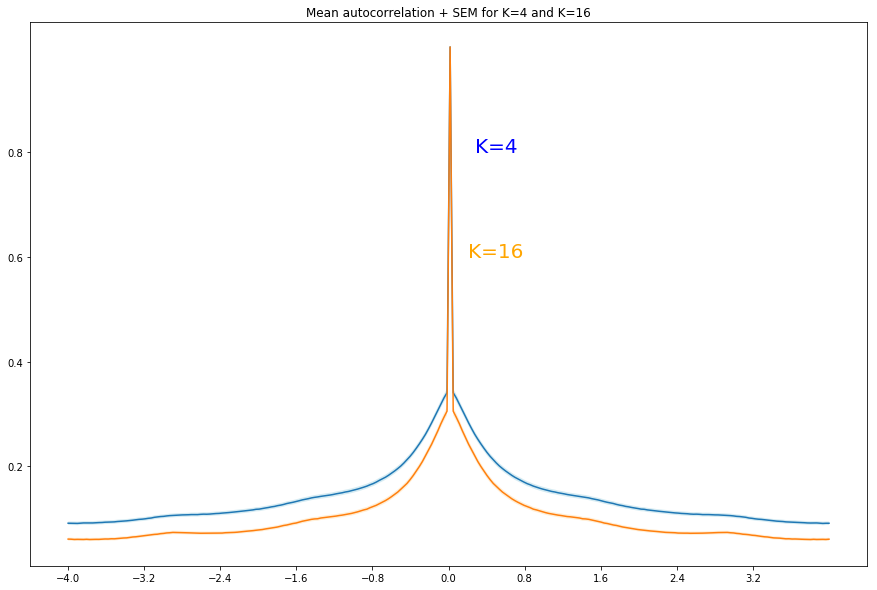

In [65]:
autocorr_4_all = [np.mean(autocorr_4, axis=0), scipy.stats.sem(autocorr_4, axis=0)]
autocorr_16_all = [np.mean(autocorr_16, axis=0), scipy.stats.sem(autocorr_16, axis=0)]
col_lig = ['lightblue', 'navajowhite']
col = ['b', 'orange']
ypos = [0.8, 0.6]
label = ['K=4', 'K=16']

fig_gabautocorr, ax_gab_autocorr = plt.subplots(figsize=(15, 10))
ax_gab_autocorr.set_xticks(np.arange(-lag_s, lag_s, lag_s/5.))
ax_gab_autocorr.set_yticks(np.arange(0, 1, 0.2))
for i, data in enumerate([autocorr_4_all, autocorr_16_all]):
    ax_gab_autocorr.plot(x_ran, data[0])
    ax_gab_autocorr.fill_between(x_ran, data[0] - data[1], data[0] + data[1], facecolor=col_lig[i], alpha=0.5)
    ax_gab_autocorr.text(0.5, ypos[i], label[i], horizontalalignment='center', fontsize=20, color=col[i])
 
ax_gab_autocorr.set_title('Mean autocorrelation + SEM for K=4 and K=16')

fig_gabautocorr.savefig('{}/roi_session_1_gab4_16_autocorr_av.png'.format(figdir_roi), bbox_inches='tight')

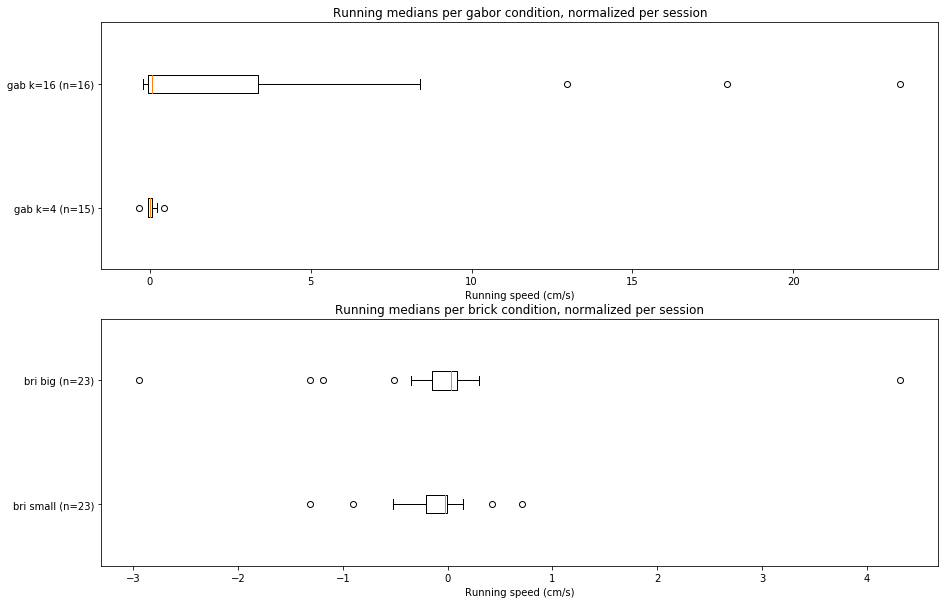

In [66]:
# median running to K=16 vs K=4 - median running overall and same for bricks (across all sessions)
run_gab_4_all = []
run_gab_16_all = []
run_bri_big_all = []
run_bri_small_all = []
for sess in [x for s in all_sess for x in s]:
    med_run = np.median(sess.run[:])
    try:
        run_gab_4 = np.median(sess.run[sess.gabors.get_frames_by_criteria(stimPar2=4, first_fr=False, by='frame')]) - med_run # excludes grayscr
        run_gab_4_all.extend([run_gab_4])
    except:
        pass
    try:
        run_gab_16 = np.median(sess.run[sess.gabors.get_frames_by_criteria(stimPar2=16, first_fr=False, by='frame')]) - med_run # excludes grayscr
        run_gab_16_all.extend([run_gab_16])
    except:
        pass
    try:
        run_bri_big = np.median(sess.run[sess.bricks.get_frames_by_criteria(stimPar1=128, first_fr=False, by='frame')]) - med_run
        run_bri_big_all.extend([run_bri_big])
    except:
        pass
    try:
        run_bri_small = np.median(sess.run[sess.bricks.get_frames_by_criteria(stimPar1=256, first_fr=False, by='frame')]) - med_run
        run_bri_small_all.extend([run_bri_small])
    except:
        pass

gab_lab = ['gab k=4', 'gab k=16']
gab_data = [run_gab_4_all, run_gab_16_all]
bri_lab = ['bri small', 'bri big']
bri_data = [run_bri_small_all, run_bri_big_all]

titles = ['Running medians per {} condition, normalized per session'.format(stim) for stim in ['gabor', 'brick']]
          
fig_box, ax_box = plt.subplots(nrows=2, figsize=(15, 10))

gab_labels = ['{} (n={})'.format(lab, len(data)) for lab, data in zip(gab_lab, gab_data)]
ax_box[0].boxplot(gab_data, vert=False)
ax_box[0].set_title(titles[0])
ax_box[0].set_xlabel('Running speed (cm/s)')
ax_box[0].set_yticklabels(gab_labels)
          
bri_labels = ['{} (n={})'.format(lab, len(data)) for lab, data in zip(bri_lab, bri_data)]
ax_box[1].boxplot(bri_data, vert=False)
ax_box[1].set_title(titles[1])
ax_box[1].set_xlabel('Running speed (cm/s)')
ax_box[1].set_yticklabels(bri_labels)


fig_box.savefig('{}/run_stats_by_param.png'.format(figdir_run), bbox_inches='tight')


In [1]:
# plot ROI traces across gabor nosurp->nosurp vs nosurp->surp , session 1 low
rand=False
pre=3
post=5
gab_st_surp_chunks = []
gab_no_surp_chunks = []
for i, sess in enumerate(first_sess_lo):
    print(sess.session)
    # start surp
    st_surp_seg = sess.gabors.get_2pframes_by_seg(sess.gabors.get_segs_by_criteria(surp=1, by='seg', remconsec=True), first=True)
    gab_st_surp_chunks.append(sess.gabors.get_roi_chunk_stats(st_surp_seg, pre, post, byroi=False, rand=rand, stats=plot_stat))
    # no surp
    no_surp_seg = sess.gabors.get_segs_by_criteria(surp=0, gaborframe=0, by='seg')
    rev = list(reversed(no_surp_seg))
    # get non surprise segs somewhat staggered, while preventing overlapping windows
    temp = []
    count=0
    min_set = np.ceil((pre+post+1)/sess.gabors.set_len_s)
    max_set = np.ceil(1.5*(pre+post)/sess.gabors.set_len_s)
    set_pre = np.ceil(pre/sess.gabors.set_len_s).astype(int)
    sep = np.random.choice(np.arange(min_set, max_set)) # get a set separation value
    for j, seg in enumerate(rev):
        if j >= len(rev)-set_pre:
            break
        elif j==0 or seg == rev[j+set_pre]+sess.gabors.n_seg_per_set*set_pre:
            if count == sep:
                temp.extend([seg])
                count=0
            else:
                count += 1
                sep = np.random.choice(np.arange(min_set, max_set)) # get a new value
        else:
            count=0
    no_surp_fr = sess.gabors.get_2pframes_by_seg(list(reversed(temp)), first=True)
    gab_no_surp_chunks.append(sess.gabors.get_roi_chunk_stats(no_surp_fr, pre, post, byroi=False, rand=rand, stats=plot_stat))
    
# draw lines
h_bars = [0.9] # heavy at 0
# light at each segment (+1 for gray and +1 for end)
seg_bars = [0, 0.3, 0.6]
labels_1 = ['no surp', 'A', 'B', 'C', 'E']
labels_2 = ['no surp', 'A', 'B', 'C', 'D']
xpos = [-1.5, 0.15, 0.45, 0.75, 1.05]

# plot
fig_gab_surp_nosurp, ax_gab_surp_nosurp = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i in range(n_mice):
    plot_chunks(ax_gab_surp_nosurp[i/2][i%2], gab_no_surp_chunks[i], stats=plot_stat,
                title='Mouse {} - {} dF/F across gabor sequences \n (session 1)'
                .format(i+1, plot_stat),
                hbars=h_bars, bars=seg_bars, lw=0.8, labels=labels_2, xpos=xpos, t_hei=0.7, col='b')
    plot_chunks(ax_gab_surp_nosurp[i/2][i%2], gab_st_surp_chunks[i], stats=plot_stat,
                title='Mouse {} - {} dF/F across gabor sequences \n (session 1)'
                .format(i+1, plot_stat), 
                hbars=h_bars, bars=seg_bars, lw=0.8, btwc='navajowhite', labels=labels_1, xpos=xpos, t_hei=0.9, col='orange')
fig_gab_surp_nosurp.savefig('{}/roi_session_1_gabors_surp_nosurp.png'.format(figdir_roi), bbox_inches='tight')



NameError: name 'first_sess_lo' is not defined